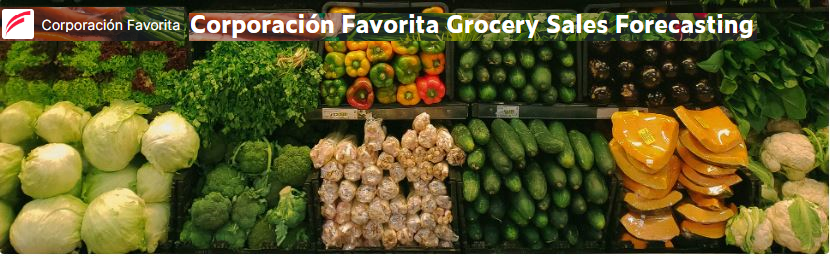

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

# Business Problem Statement
Develop a model to accurately forcast Product Sales based on historical sales data of over 200,000 products on their shelves.  

#### Benefits of such a model:  
 * Efficient inventory management in each of the stores.
 * Reduce human resources and cost in forcasting in sales across hundreds of supermarkets and thousands of products in varied seasonal tastes.  

#### How is it done now:  
   Currently, they rely on subjective forcasting based on very little data and automation. 
   
#### Current challenges: 
If they predict a little over, and grocers are stuck with overstocked and perishable goods. If guessed little under, loss of revenue and customer dissafisfaction.



### Evaluation Metrics

The evaluation metric and loss function we use is:

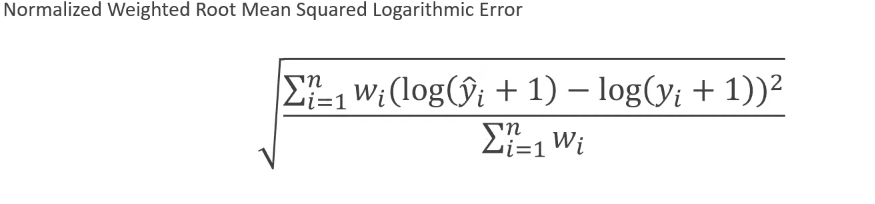

Where:

\\(n\\) is the total number of observations in the (public/private) data set,  
\\(pred\\) is your prediction of sales, and  
\\(actual\\) is the actual sales for \\(i\\).  
\\(\log(x)\\) is the natural logarithm of \\(x\\)  

**High Level Steps**:  
This is a Supervised Machine Learning problem. Regression models such as linear regression, decision tree and ensemble models such as RandomForest, XGBoost will be trained to predict weekly adjusted demand using Scikit Learn and XGBoost. We will use Pandas, Numpy, Matplotlib, Seaborn and Plotly to perform exploratory data analysis and later prepare the data for machine learning. We will do the following

* Install and Import libraries
* Read data from the datafiles to respective dataframes
* EDA - Explore Datasets
* Data Cleanup and Data Imputation
* Merge different files as required
* Transform Data
* EDA - Data Visualization
* Feature Engineering
* Data preparation - Train Val Split, Encoding, Imputing and Scale Numerical values
* Select input features
* Define evaluation metrics
* Define baseline model
* Try different ML models
* Select best model without hyperparameter tuning
* Hyperparameter tuning for select models
* Make predictions
* Save the best model
* Summarize the learnings

### Install important Libraries

In [1]:
!pip install opendatasets --upgrade --quiet
!pip install --upgrade xgboost --quiet
!pip install --upgrade lightgbm --quiet
!pip install category_encoders --quiet
!pip install py7zr --quiet

In [2]:
#import OS &  Data file libraries
import os
import opendatasets as od
from zipfile import ZipFile

#Import Data analysis libraries

import numpy as np
import pandas as pd

#Data Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Jupyter notebook visualization font and figure display settings
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['font.size']=14
matplotlib.rcParams['figure.figsize']=(18,6)
matplotlib.rcParams['figure.facecolor']='#00000000'


# Exploring the Dataset

#### Download data from Kaggle and Extract zip files.

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data'
od.download(dataset_url)

Skipping, found downloaded files in "./favorita-grocery-sales-forecasting" (use force=True to force download)


In [4]:
os.listdir('favorita-grocery-sales-forecasting')

['items.csv.7z',
 'sample_submission.csv.7z',
 'train.csv.7z',
 'stores.csv',
 'sample_submission.csv',
 'train.csv',
 'holidays_events.csv',
 'oil.csv.7z',
 'transactions.csv',
 'stores.csv.7z',
 'items.csv',
 'oil.csv',
 'test.csv',
 'holidays_events.csv.7z',
 'transactions.csv.7z',
 'test.csv.7z']

In [5]:
#Helper function to unzip all the datafiles

import py7zr

dir_path='favorita-grocery-sales-forecasting'


for dirname, _, filenames in os.walk(dir_path):
    for filename in filenames:
        archive = py7zr.SevenZipFile(os.path.join(dir_path, filename), mode='r')
        archive.extractall(path=dir_path)
        archive.close()


Bad7zFile: ignored

In [ ]:
!ls -l favorita-grocery-sales-forecasting/*csv

Load the csv file data into Pandas dataframe

Load Data 1% of the rows of the training datafile into dataframe.

In [ ]:
path='favorita-grocery-sales-forecasting'

In [ ]:
%%time
# Read random rows rows from train into dataframe, this dataframe has all measures
train_data_types={'id':'int32', 'store_nbr':'int32', 'item_nbr':'int32', 'unit_sales':'float32', 'onpromotion':'boolean'}

import random

# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
random.seed(42)
def train_skip_rows(row_idx):
  p = 0.01  # 1% of the lines
  if row_idx==0:
    return False
  return random.random()>p

raw_train_df = pd.read_csv(
         path+'/train.csv',
         dtype=train_data_types,
         parse_dates=['date'],
         header=0, 
         skiprows=train_skip_rows
)


CPU times: user 59.7 s, sys: 1.73 s, total: 1min 1s
Wall time: 1min 1s


In [ ]:
%%time
# Read random rows rows from train into dataframe, this dataframe has all measures
train_data_types={'id':'int32', 'store_nbr':'int32', 'item_nbr':'int32', 'unit_sales':'float32', 'onpromotion':'boolean'}

parse_date=['date']

raw_train_df = pd.read_csv(
         path+'/train.csv',
         dtype=train_data_types,
         parse_dates=['date']
)

item_data_types={ 'item_nbr':'int32', 'class':'int32', 'perishable':'int32'}
items_df= pd.read_csv(path+'/items.csv',dtype=item_data_types,header=0 )

oil_df= pd.read_csv(path+'/oil.csv',parse_dates=parse_date, header=0 )

store_data_types={ 'store_nbr':'int32', 'cluster':'int32'}
stores_df= pd.read_csv(path+'/stores.csv',dtype=store_data_types, header=0 )

transactions_data_types={ 'store_nbr':'int32', 'transactions':'int32'}
transactions_df= pd.read_csv(path+'/transactions.csv',dtype=transactions_data_types,parse_dates=parse_date,header=0 )

holidays_df= pd.read_csv(path+'/holidays_events.csv',parse_dates=parse_date,header=0 )



test_data_types={'id':'int32', 'store_nbr':'int32', 'item_nbr':'int32', 'onpromotion':'boolean'}
raw_test_df = pd.read_csv(path+'/test.csv',dtype=test_data_types,parse_dates=parse_date,header=0) 



#### Exploring Datasets

Training Dataset

In [ ]:
raw_train_df.head(5)

In [ ]:
raw_train_df.info()

In [ ]:
raw_train_df.describe().round().transpose()

In [ ]:
raw_train_df.date.describe(datetime_is_numeric=True)

In [ ]:
raw_train_df[['date','store_nbr','item_nbr']].duplicated().sum()

**Train.csv:**
*  id : indicates unique transaction id for each sale or returns.
*  store_nbr: Store number from 1 to 54 doesn't indicate any ranking.
*  item_nbr:  Has about 4,100 unique items. item number doesn't indicate any ranking.
*  date: Date corresponding sale dates between Jan-2013 to 15-Aug-2017.
*  onpromotion: tells whether that item_nbr was on promotion for a specified date and store_nbr.
*  unit_sales: units sold per transaction, can be integer or float. 

**Observations:**
*  onpromotion- has 16% of values has null values.
*  unit_sales-
      * Has average sales of 9 and median sales of 4 units. 
      * 75% of transactions has less than 9 units sold. 
      * Maximum sold units 6872, there are few outliers.
      * Has negative values. Negative value represets returns. These need to be removed from the dataset as instructed in the competition.
      * This is the target value that will be predicted for the Test dataset
*  no duplicate rows.Meaning each row is an aggregate of all the units sold of that item for that store on that day.

Testing Dataset

In [ ]:
raw_test_df.isna().sum()

In [ ]:
raw_test_df.describe().round().transpose()

In [ ]:
raw_test_df.date.describe(datetime_is_numeric=True)

**Test.csv**

* store_nbr: Store numbers 1 to 54. All store number exists in Training dataset.  
* item_nbr: Some item numbers do not exist in the Training dataset.  
* No null values in the Test dataset.

Stores Dataset  


In [ ]:
stores_df.info()

In [ ]:
stores_df.describe().round().transpose()

In [ ]:
stores_df.store_nbr.duplicated().sum()

In [ ]:
stores_df.rename(columns={'type':'store_type'},inplace=True)

**Stores.csv**  
Has Store location information.  
No null values.  
No duplicate values.  
rename column `type` to `store_type`.  
`cluster` is a grouping of similar stores.

Oil Dataset

In [ ]:
oil_df.describe()

In [ ]:
oil_df.info()

In [ ]:
oil_df.date.describe(datetime_is_numeric=True)

In [ ]:
oil_df.date.duplicated().sum()

**Oil.csv**  
* Has Daily oil prices.  
* price(dcoilwtico) has few Null Values.  
* The dates covers both Test as well as Training dataset date ranges.

Items Datasets

In [25]:
items_df.head(2)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0


In [26]:
items_df.describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
item_nbr,4100.0,1251436.0,587687.0,96995.0,818111.0,1306198.0,1904918.0,2134244.0
class,4100.0,2170.0,1485.0,1002.0,1068.0,2004.0,2990.0,7780.0
perishable,4100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [27]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_nbr    4100 non-null   int32 
 1   family      4100 non-null   object
 2   class       4100 non-null   int32 
 3   perishable  4100 non-null   int32 
dtypes: int32(3), object(1)
memory usage: 80.2+ KB


In [28]:
items_df.item_nbr.duplicated().sum()

0

**Items.csv**  
* Has items information, such as product family , perishable or not.  
* Has no null values.  
* Has no duplicate values.  
* `perishable` column value is used in calculating the Evaluation Metric (weight). if perishable is 1 then weight is 1.25 else it is 1.0, 

Transactions Dataset

In [29]:
transactions_df.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


In [30]:
transactions_df.describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,27.0,16.0,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1695.0,963.0,5.0,1046.0,1393.0,2079.0,8359.0


In [31]:
transactions_df.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [32]:
transactions_df.date.describe(datetime_is_numeric=True)

count                            83488
mean     2015-05-20 16:07:40.866232064
min                2013-01-01 00:00:00
25%                2014-03-27 00:00:00
50%                2015-06-08 00:00:00
75%                2016-07-14 06:00:00
max                2017-08-15 00:00:00
Name: date, dtype: object

**Transactions.csv**  
The count of sales transactions for each date, store_nbr combination.  
No Null values.  
Date range is only for training data.

Holidays Dataset

In [33]:
holidays_df.head(2)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False


In [34]:
holidays_df.isna().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [35]:
holidays_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         350 non-null    datetime64[ns]
 1   type         350 non-null    object        
 2   locale       350 non-null    object        
 3   locale_name  350 non-null    object        
 4   description  350 non-null    object        
 5   transferred  350 non-null    bool          
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 14.1+ KB


In [36]:
holidays_df.rename(columns={'type':'holiday_type'},inplace=True)

**Holidays.csv**
* Has Holiday related information.  
* A transferred day is more like a normal day than a holiday.  
* To find the Holiday, check the type 'Transfer'


Make a working copy of the train & test dataFrame

In [37]:
train_df=raw_train_df.copy(deep=True)
test_df=raw_test_df.copy(deep=True)

In [38]:
train_df.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,<NA>
1,1,2013-01-01,25,105574,1.0,<NA>
2,2,2013-01-01,25,105575,2.0,<NA>


In [39]:
test_df.head(3)

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False


### Data CleanUp and Data Imputation

Training Dataset (train_df)
1. fill `onpromotion` null value with False
2. exract only date from the timestamp date column.
3. Delete rows that have `unit_sales` less than 0.001.
4. no duplicate rows.


In [40]:
#fill the null onpromotion with False as that is the most frequently occuring value
train_df.onpromotion.fillna(False, inplace=True)

In [41]:
train_df['date']=pd.to_datetime(train_df['date'].dt.date)

In [42]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int32         
 1   date         datetime64[ns]
 2   store_nbr    int32         
 3   item_nbr     int32         
 4   unit_sales   float32       
 5   onpromotion  boolean       
dtypes: boolean(1), datetime64[ns](1), float32(1), int32(3)
memory usage: 3.0 GB


Delete rows that have `unit_sales` less than .001 as instructed by Kaggle

In [43]:
train_df.drop(train_df[train_df.unit_sales<.001].index,inplace=True)

Check for Outliers

In [44]:
train_df.unit_sales.describe().round().astype('float32')

count    125489248.0
mean             9.0
std             24.0
min              0.0
25%              2.0
50%              4.0
75%              9.0
max          89440.0
Name: unit_sales, dtype: float32

In [45]:
px.box(train_df,x="unit_sales")

`unit_sales` Max value is 6872,Mean is 9, Median is 4 and  75% of the data is below 9. Data is skewed, and the outliers are impacting the mean in a big way.
We will delete all the rows whose value is greater than 2000.

In [46]:
train_df[train_df.unit_sales>2000].merge(items_df,on='item_nbr')

items whose `unit_sales` is more than 2000 are listed above. Closer look at the items shows , either tthere is a unusually high bulk order or error in data entry. so we will replace all the high values with 2000.

In [ ]:
#train_df.drop(train_df[train_df.unit_sales>2000].index, inplace = True)
train_df.unit_sales=np.clip(train_df.unit_sales,0.00001,2000)

Testing Dataset (test_df)
1. exract only date from the timestamp date column.
2. no duplicate rows.


In [ ]:
test_df['date']=pd.to_datetime(test_df['date'].dt.date)

Stores Dataset (stores_df)
1. no duplicate rows
2. no null values
3. Rename column name type to store_type


In [ ]:
stores_df.rename({'type':'store_type'},inplace=True)

Items Datasets (items_df)
1. no duplicate rows
2. no null values

In [ ]:
items_df.duplicated(keep=False).sum()

In [ ]:
items_df.isna().sum()

Oil Datasets(oil_df)
1. exract only date from the timestamp date column.
2. there are 48 prices missing.

In [ ]:
oil_df['date']=pd.to_datetime(oil_df['date'].dt.date)


In [ ]:
oil_df.isna().sum()

Transactions Datsets(transactions_df)
1. exract only date from the timestamp date column.
2. no duplicates

In [ ]:
transactions_df['date']=pd.to_datetime(transactions_df['date'].dt.date)

Holiday Datasets (holidays_df)
1. exract only date from the timestamp date column.
2. Drop records if `transferred` value is True as these are normal working days.

In [ ]:
#exract only date from the timestamp date column.
holidays_df['date']=pd.to_datetime(holidays_df['date'].dt.date)

In [ ]:
#Drop records if `transferred` value is True as these are normal working days.

holidays_df.drop(holidays_df[holidays_df.transferred==True].index, inplace=True)

Transactions Dataset (transactions_df)
1. exract only date from the timestamp date column.

In [ ]:
#exract only date from the timestamp date column.
transactions_df['date']=pd.to_datetime(transactions_df['date'].dt.date)

In [59]:
train_df.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,False
1,1,2013-01-01,25,105574,1.0,False
2,2,2013-01-01,25,105575,2.0,False


### Join the Tables to create a denormalized DataFrame

In [60]:
def denorm_dataset(df):
  df=pd.merge(df,stores_df,how='left',on='store_nbr')
  df=pd.merge(df,items_df,how='left',on='item_nbr')
  df=pd.merge(df,oil_df,how='left', on='date')
  df=pd.merge(df,transactions_df,how='left', on=['date','store_nbr'])

  return df


In [61]:
holidays_df.head(3)

,date,holiday_type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


DeNormalize Training Dataset

In [62]:
train_df=denorm_dataset(train_df)

DeNormalize Testing Dataset

In [63]:
test_df=denorm_dataset(test_df)

In [64]:
train_df.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,store_type,cluster,family,class,perishable,dcoilwtico,transactions
0,0,2013-01-01,25,103665,7.0,False,Salinas,Santa Elena,D,1,BREAD/BAKERY,2712,1,NaN,770.0
1,1,2013-01-01,25,105574,1.0,False,Salinas,Santa Elena,D,1,GROCERY I,1045,0,NaN,770.0
2,2,2013-01-01,25,105575,2.0,False,Salinas,Santa Elena,D,1,GROCERY I,1045,0,NaN,770.0


### Feature Engineering

**Data Imputation.**    


Check the null values in the train & test dataframes.

In [65]:
train_df.count()

id              125489245
date            125489245
store_nbr       125489245
item_nbr        125489245
unit_sales      125489245
onpromotion     125489245
city            125489245
state           125489245
store_type      125489245
cluster         125489245
family          125489245
class           125489245
perishable      125489245
dcoilwtico       84967953
transactions    125274629
dtype: int64

In [66]:
train_df.isna().sum()

id                     0
date                   0
store_nbr              0
item_nbr               0
unit_sales             0
onpromotion            0
city                   0
state                  0
store_type             0
cluster                0
family                 0
class                  0
perishable             0
dcoilwtico      40521292
transactions      214616
dtype: int64

In [67]:
test_df.count()

id              3370464
date            3370464
store_nbr       3370464
item_nbr        3370464
onpromotion     3370464
city            3370464
state           3370464
store_type      3370464
cluster         3370464
family          3370464
class           3370464
perishable      3370464
dcoilwtico      2527848
transactions          0
dtype: int64

In [68]:
test_df.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
family                0
class                 0
perishable            0
dcoilwtico       842616
transactions    3370464
dtype: int64

Training Datasets.  
`onpromotion`, `dcoilwtico`(oil prices) and `transactions`(count) columns has null values. We will fill the null values with appropriate values.

`onpromotion`'s null value is replaced with False (meaning no promotion of that day)

In [69]:
#fill the null onpromotion with False as that is the most frequently occuring value
train_df.onpromotion.fillna(False, inplace=True)

`dcoilwtico` column which represents oil prices on that day. we will replace the null value with previous days value.

In [70]:
train_df.dcoilwtico.fillna(method='ffill',inplace=True)

If the very first row has null then we will fill it with the next value.

In [71]:
train_df.dcoilwtico.fillna(method='bfill',inplace=True)

Testing Dataset.

In [72]:
test_df.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
family                0
class                 0
perishable            0
dcoilwtico       842616
transactions    3370464
dtype: int64

`dcoilwtico` column which represents oil prices on that day. we will replace the null value with previous days value.

In [73]:
test_df.dcoilwtico.fillna(method='ffill',inplace=True)

If the very first row has null then we will fill it with the next value.

In [74]:
test_df.dcoilwtico.fillna(method='bfill',inplace=True)

In [75]:
train_df.isna().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
family               0
class                0
perishable           0
dcoilwtico           0
transactions    214616
dtype: int64

In [76]:
test_df.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
family                0
class                 0
perishable            0
dcoilwtico            0
transactions    3370464
dtype: int64

**Add New Columns.**  
Columns:  
1.  `isHoliday` to check if the store location's area has a holiday.
Default is set to 0, If `transferred` is False and If the Locale is 'National', then all the stores will be marked 1 on that day. Else if 'locale' is Regional, then all the stores in the state  are set to 1 , else if 'locale' is 'Local' then all the stores in the city will be set to 1.

In [77]:
def is_holiday(row):

  if len(holidays_df[(holidays_df.date==row.date) & (holidays_df.locale=='National') & ~(holidays_df.transferred) ])>0:
    holiday_type=holidays_df.loc[(holidays_df.date==row.date) & (holidays_df.locale=='National')]['holiday_type'].to_list()[0]
    isHoliday=1
  elif len(holidays_df[(holidays_df.date==row['date']) & (holidays_df.locale=='Regional') & (holidays_df.locale_name==row['state']) & ~(holidays_df.transferred)])>0:
    holiday_type=holidays_df.loc[(holidays_df.date==row['date']) & (holidays_df.locale=='Regional') & (holidays_df.locale_name==row['state'])]['holiday_type'].to_list()[0]
    isHoliday=1
  elif len(holidays_df[(holidays_df.date==row.date) & (holidays_df.locale=='Local') & (holidays_df.locale_name==row['city'])& ~(holidays_df.transferred)]) >0:
    holiday_type=holidays_df.loc[(holidays_df.date==row.date) & (holidays_df.locale=='Local') & (holidays_df.locale_name==row['city'])]['holiday_type'].to_list()[0]
    isHoliday=1
  else:
    holiday_type='noholiday'
    isHoliday=0

  return pd.Series([isHoliday,holiday_type],index=['isHoliday','holiday_type'])
    


In [78]:
store_holidays_df=pd.DataFrame(holidays_df['date'].unique(),columns=['date'])

In [79]:
store_holidays_df=store_holidays_df.merge(stores_df, how='cross')

In [80]:
%%time
store_holidays_df[['isHoliday','holiday_type']]=store_holidays_df.apply(lambda row: is_holiday(row), axis=1)


CPU times: user 40.6 s, sys: 1.4 s, total: 42 s
Wall time: 40.2 s


Merge `store_holidays_df` with the `train_df` or `test_df`.

In [81]:
def set_store_holiday(df):
  #join store_holidays_df with test or train dataset.
  df=pd.merge(df,store_holidays_df[['date','store_nbr','isHoliday','holiday_type']],how='left', on=['date','store_nbr'])

  # Replace null value to 0 for isHoliday column.
  df.isHoliday.fillna(0, inplace=True)
  # Replace null value to nohilday for holiday_type column.
  df.holiday_type.fillna('noholiday', inplace=True)


  return df

In [82]:
store_holidays_df[['date','store_nbr','isHoliday','holiday_type']].count()

date            16200
store_nbr       16200
isHoliday       16200
holiday_type    16200
dtype: int64

In [83]:
#Set isHoliday for each store and date in Training dataset
train_df=set_store_holiday(train_df)

In [84]:
#Set isHoliday for each store and date in Training dataset
test_df=set_store_holiday(test_df)

2. Add Columns to store parts of the data such as Year, Day etc. 

In [85]:
import datetime as dt
def parse_date(df):
  df['day']=df.date.dt.day
  df['weekday']=df.date.dt.weekday
  df['month']=df.date.dt.month
  df['year']=df.date.dt.year


In [86]:
#Add date related columns to train_df
parse_date(train_df)

In [87]:
#Add date related columns to test_df
parse_date(test_df)

3. Add a column to check if the day is a weekend or weekday.

In [88]:
train_df['isWeekend']=train_df.weekday.map({0:0,1:0,2:0,3:0,4:0,5:1,6:1})
test_df['isWeekend']=test_df.weekday.map({0:0,1:0,2:0,3:0,4:0,5:1,6:1})

4. Add a column to check if the day is first 4 days of the month when people are more likely to spend.

In [89]:
train_df['payday']=train_df.day.map(lambda x: 1 if x in (1,2,3,4) else 0)
test_df['payday']=test_df.day.map(lambda x: 1 if x in (1,2,3,4) else 0)

5.  Add columns `date_ord` a date ordinal value to track the numerical progression of the date.

In [90]:
import datetime as dt
train_df['date_ord']= train_df['date'].map(dt.datetime.toordinal)
test_df['date_ord']= test_df['date'].map(dt.datetime.toordinal)

Add a column `weight` to give weight to perishable(1.25) and a 1 to non-perishable item.

In [91]:
train_df['weight']=train_df.perishable.map({1:1.25,0:1})
test_df['weight']=test_df.perishable.map({1:1.25,0:1})

Change the datatype to int32 to save space and for efficiency.

In [92]:
#int32_columns=['store_nbr','item_nbr','onpromotion','cluster','class','perishable','day','weekday','month','year','isWeekend','payday']
#float32_columns=[  'dcoilwtico']

In [93]:
#train_df[int32_columns]=train_df[int32_columns].astype('int32')
#train_df[float32_columns]=train_df[float32_columns].astype('float32')


In [94]:
#test_df[int32_columns]=test_df[int32_columns].astype('int32')
#test_df[float32_columns]=test_df[float32_columns].astype('float32')

Verify that no null values exists in `train_df` & `test_df`.

In [95]:
test_df.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
family                0
class                 0
perishable            0
dcoilwtico            0
transactions    3370464
isHoliday             0
holiday_type          0
day                   0
weekday               0
month                 0
year                  0
isWeekend             0
payday                0
date_ord              0
weight                0
dtype: int64

In [96]:
train_df.isna().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
family               0
class                0
perishable           0
dcoilwtico           0
transactions    214616
isHoliday            0
holiday_type         0
day                  0
weekday              0
month                0
year                 0
isWeekend            0
payday               0
date_ord             0
weight               0
dtype: int64

#### Impute missing transactions values
`transactions` column which represents number of transactions per-store per-day. Since transactions on that day at that store depends on the 'day' itself, so simple mean won't cut it.We will replace the null values with a predicted value from a ML model.

In [97]:
input_trxn=['date_ord','store_nbr','day','weekday','isHoliday','payday']
trgt_trxn=['transactions']

In [98]:
trxn_data_df=train_df.loc[train_df.transactions.notnull()]

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
input_training_txn_df, input_val_data_txn_df, target_training_txn_df, target_val_txn_df = train_test_split(trxn_data_df[input_trxn], trxn_data_df[trgt_trxn], test_size=0.3,random_state=42)

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42, n_jobs=-1, max_depth=15)
rfr.fit(input_training_txn_df,y=target_training_txn_df.values.ravel())

In [ ]:
#Predict unit sales for Training Data
training_trxn_preditions= rfr.predict(input_training_txn_df)
#Predict unit sales for Testing Data
val_trxn_preditions= rfr.predict(input_val_data_txn_df)

In [ ]:
print("Training mean_squared_error for  : {} ".format(mean_squared_error(target_training_txn_df, training_trxn_preditions,squared=False)))
print("Validation mean_squared_error for : {} ".format(mean_squared_error(target_val_txn_df, val_trxn_preditions,squared=False)))

In [ ]:
%%time
from xgboost import XGBRegressor
xgb=XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squarederror',eval_metric='rmse' ,tree_method='gpu_hist',max_depth=15,learning_rate=0.1)
xgb=xgb.fit(input_training_txn_df,y=target_training_txn_df.values.ravel())

In [ ]:
#Predict unit sales for Training Data
training_trxn_preditions= xgb.predict(input_training_txn_df)
#Predict unit sales for Testing Data
val_trxn_preditions= xgb.predict(input_val_data_txn_df)

In [ ]:
print("Training mean_squared_error for  : {} ".format(mean_squared_error(target_training_txn_df, training_trxn_preditions,squared=False)))
print("Validation mean_squared_error for : {} ".format(mean_squared_error(target_val_txn_df, val_trxn_preditions,squared=False)))

In [ ]:
%%time
import lightgbm as lgbm
lgb=lgbm.LGBMRegressor(random_state=42, n_jobs=-1 )
lgb.fit(input_training_txn_df,y=target_training_txn_df.values.ravel())

CPU times: user 14.4 s, sys: 99.3 ms, total: 14.5 s
Wall time: 2.08 s


LGBMRegressor(random_state=42)

In [ ]:
#Predict unit sales for Training Data
training_trxn_preditions= lgb.predict(input_training_txn_df)
#Predict unit sales for Testing Data
val_trxn_preditions= lgb.predict(input_val_data_txn_df)

In [ ]:
print("Training mean_squared_error for  : {} ".format(mean_squared_error(target_training_txn_df, training_trxn_preditions,squared=False)))
print("Validation mean_squared_error for : {} ".format(mean_squared_error(target_val_txn_df, val_trxn_preditions,squared=False)))

Training mean_squared_error for  : 189.3468037653154 
Validation mean_squared_error for : 190.20732860045635 


Since XGBoost give the least RMSE value, we will impute the null `transactions` value with the predicted value of this model.

In [ ]:
trxn_na_df=train_df.loc[train_df.transactions.isna()].copy(deep=True)

In [ ]:
train_df.loc[[71211,71212]]['transactions']

71211    1911.0
71212       NaN
Name: transactions, dtype: float64

In [ ]:
trxn_na_df.loc[[71212]]['transactions']

71212   NaN
Name: transactions, dtype: float64

Now, predict missing `transaction` values from the training dataset.

In [ ]:
trxn_na_df['transactions']= xgb.predict(trxn_na_df[['date_ord','store_nbr',	'day',	'weekday',	'isHoliday',	'payday']]).round()

In [ ]:
train_df.loc[trxn_na_df.index.tolist(),'transactions']=trxn_na_df['transactions']

In [ ]:
train_df.loc[[71211,71212,71213,71214]]['transactions']

71211    1911.0
71212     982.0
71213     982.0
71214     982.0
Name: transactions, dtype: float64

Now, predict missing transaction values from the all of test dataset.

In [ ]:
%%time
test_df['transactions']= xgb.predict(test_df[['date_ord','store_nbr',	'day',	'weekday',	'isHoliday',	'payday']])

CPU times: user 36.4 s, sys: 334 ms, total: 36.8 s
Wall time: 5.34 s


One Final Check for null values.

In [ ]:
train_df.isna().sum()

id              0
date            0
store_nbr       0
item_nbr        0
unit_sales      0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
family          0
class           0
perishable      0
dcoilwtico      0
transactions    0
isHoliday       0
holiday_type    0
day             0
weekday         0
month           0
year            0
isWeekend       0
payday          0
date_ord        0
weight          0
dtype: int64

In [ ]:
test_df.isna().sum()

id              0
date            0
store_nbr       0
item_nbr        0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
family          0
class           0
perishable      0
dcoilwtico      0
transactions    0
isHoliday       0
holiday_type    0
day             0
weekday         0
month           0
year            0
isWeekend       0
payday          0
date_ord        0
weight          0
dtype: int64

Final check for non-duplicate(date,store_nbr,item_nbr) combo.

In [ ]:
train_df.loc[train_df.duplicated(subset=['date','store_nbr','item_nbr'],keep=False)].sort_values('date',ascending=False)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,store_type,cluster,...,isHoliday,holiday_type,day,weekday,month,year,isWeekend,payday,date_ord,weight


In [ ]:
test_df.loc[test_df.duplicated(subset=['date','store_nbr','item_nbr'],keep=False)].sort_values('date',ascending=False)

,id,date,store_nbr,item_nbr,onpromotion,city,state,store_type,cluster,family,...,isHoliday,holiday_type,day,weekday,month,year,isWeekend,payday,date_ord,weight


Save the `train_df` & `test_df` as a parquet file.

In [ ]:
train_df.to_parquet('ml_train_df.parquet')

In [ ]:
test_df.to_parquet('ml_test_df.parquet')

Read ml_train_df.parquet & ml_test_df.parquet and prepare it for EDA & Data Visualization.

In [ ]:
ml_train_df=pd.read_parquet('ml_train_df.parquet')
ml_train_df.onpromotion=ml_train_df.onpromotion.astype('int8')


## Exploratory Data Analysis (EDA)

Basic information about the training dataset:  
*  The sample size of the training dataset is1.2 million rows which is about 1% of the dataset and has no null values.
* Each row has info of units sold in each of its stores per item per day. 
* Each store is differentaied based on the combination of features such as its number,city,state etc.
*  Each row has info item units sold on that day.
*  The data is between 01-01-2013 to 15-08-2017.
*  The target column is `unit_sales` and will be predicted by ML Models.
*  There are 54 stores and 4007 items.
*  The sales depends on a combination of different features such as store location, item type, if holiday on that day etc.


Columns, thier meaning and datatypes.


Column Definition:  

date — date of the sale  
store_nbr — store number of the sale  
* city - City in which the store is located
* state- State in which the store is located
* store_type - Store Category
* cluster - is a grouping of similar stores  

item_nbr — item number of the sale  
* family - item category
* class -  item class
* perishable - 1 if item is perishable, 0 otherwise.

onpromotion — whther the item has promotion on that item in this store. 
dcoilwtico - Daily oil price in the Country.  
unit_sales -  number of items sold in that store on that date. This is the Target values that needs to be predicted for the Test dataset.  

Derived Columns:    

isHoliday - set to 1 if that store area has holiday on that day.   
weight - This is a calculated field used in the evaluation metrics calculation.  
day - day from the date  
weekday - weekday from the date  
month - month from the date  
year - year from the date  
payday - 1 if first 4 days of the month  else 0
 

## Data Visualization

In [ ]:
ml_train_df.head(3)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,dcoilwtico,transactions,isHoliday,holiday_type,...,isWeekend,payday,date_ord,city,state,store_type,cluster,family,class,perishable
0,19,2013-01-01,25,119024,1.0,0,93.14,770.0,1.0,Holiday,...,0,1,734869,Salinas,Santa Elena,D,1,CLEANING,3026,0
1,662592,2013-01-18,25,119024,3.0,0,95.61,971.0,0.0,noholiday,...,0,0,734886,Salinas,Santa Elena,D,1,CLEANING,3026,0
2,28345183,2014-08-01,25,119024,1.0,0,97.86,1061.0,0.0,noholiday,...,0,1,735446,Salinas,Santa Elena,D,1,CLEANING,3026,0


In [ ]:
ml_train_df['my']=pd.to_datetime(ml_train_df['month'].astype('str')+ '-'+ ml_train_df['year'].astype('str'))

Observe Oil and sales Trends

In [ ]:
trends_df=pd.DataFrame(ml_train_df[['my','unit_sales','dcoilwtico']].groupby('my').agg(['mean']))

In [ ]:
trends_df.columns=['unit_sales','oil_price']

In [ ]:
import plotly.express as px
#from plotly.offline import plot
from plotly.subplots import make_subplots
import plotly.graph_objects as go


fig = make_subplots(rows=1, cols=2,subplot_titles=("Oil Prices Trend over the Years", "Unit Sales Trend over the Years")) 

fig.add_trace(
    go.Scatter( x=trends_df.index, y=trends_df.oil_price),
    row=1, col=1
)
fig.add_trace(
    go.Scatter( x=trends_df.index, y=trends_df.unit_sales),
    row=1, col=2
)


# Update xaxis properties
fig.update_xaxes(title_text="TimeLine", row=1, col=1)
fig.update_xaxes(title_text="TimeLine", row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text="Average Oil Price ($)", range=[0, 120], row=1, col=1)
fig.update_yaxes(title_text="Average Unit Sales", range=[0, 10], row=1, col=2)

fig.update_layout( title_text="Average Monthly Oil Prices & Average Units Sold",showlegend=False)
fig.show()


Observations:
* Oil Prices fluctuated upto 50% between the timeframe. Only 15% fluctuation was seen with sales.
*  Interestingly, There is a slight spike in the Units Sold when the price of the Oil dropped significantly. However, Units sold dropped while oil prices also dropped.
* We can assume that Unit Sales has a slight negativecorreation with the Oil Prices.

In [ ]:
#geo_sales_df=pd.DataFrame(ml_train_df[['state','city','unit_sales','transactions']].groupby(['state','city']).agg(['sum']).reset_index())
geo_sales_df=pd.DataFrame(ml_train_df[['state','city','store_nbr','unit_sales','transactions']].groupby(['state','city','store_nbr']).agg(['sum']).reset_index())

In [ ]:
geo_sales_df.columns=['state','city','store_nbr','unit_sales','transactions']

In [ ]:
fig = px.treemap(geo_sales_df, 
                 path=['state','city','store_nbr'], 
                 values='transactions',
                 color='unit_sales' , 
                 color_continuous_scale='RdBu',title="A Map of State and City of stores with most unit_sales & Transactions"
                 )

fig.show()

Observation:  
  Most of the Stores(18/54) are located in Quito ciyt of Pichincha state.  
  Higest Sales are in the Store number 44

Number of Stores operating in each year

In [ ]:
uniq_stores_per_year_df=ml_train_df[['year','store_nbr']].groupby('year').nunique()

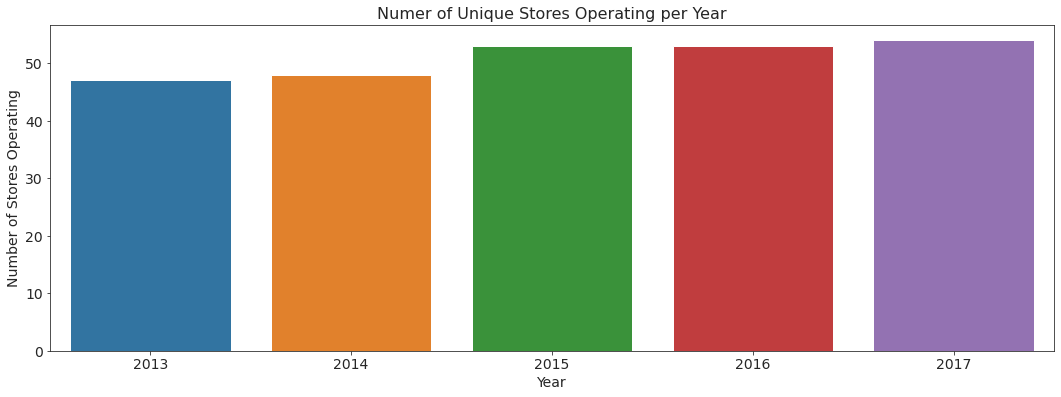

In [ ]:
plt.title('Numer of Unique Stores Operating per Year',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=uniq_stores_per_year_df.index,y=uniq_stores_per_year_df.store_nbr)
plt.xlabel("Year")
plt.ylabel("Number of Stores Operating");

Observation:  
Number of Stores operating is between 47 and 54  over five years. Many not have significant impact on the units sold.

In [ ]:
monthly_df=ml_train_df[['month','unit_sales']].groupby('month').sum().reset_index()
monthly_df['month']=monthly_df.month.map({1:'Jan', 2:'Feb', 3:'March', 4:'Apr',5:'May',6:'June',7:'July', 8:'Aug', 9:'Sept', 10:'Oct',11:'Nov',12:'Dec'})
monthly_df['unit_sales']=monthly_df['unit_sales'].round()

In [ ]:
weekday_df=ml_train_df[['weekday','unit_sales']].groupby('weekday').sum().reset_index()
weekday_df['weekday']=weekday_df.weekday.map({0:'Sunday',1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday',5:'Friday',6:'Saturday'})
weekday_df['unit_sales']=weekday_df['unit_sales'].round()

In [ ]:
store_types_df=ml_train_df[['store_type','city','item_nbr']].groupby(['store_type','city']).count().reset_index()


In [ ]:
isHoliday_df=ml_train_df[['isHoliday','unit_sales']].groupby('isHoliday').mean().reset_index()
isHoliday_df['isHoliday']=isHoliday_df.isHoliday.map({0:'Not Holiday',1:'Holiday'})
isHoliday_df['unit_sales']=isHoliday_df['unit_sales'].round()

In [ ]:
onPromotion_df=ml_train_df[['onpromotion','unit_sales']].groupby('onpromotion').mean().reset_index()
onPromotion_df['onpromotion']=onPromotion_df.onpromotion.map({0:'No Promotion',1:'Promotion'})
onPromotion_df['unit_sales']=onPromotion_df['unit_sales'].round()

In [ ]:
day_df=ml_train_df[['day','unit_sales']].groupby('day').sum().reset_index()
day_df['unit_sales']=day_df['unit_sales'].round()

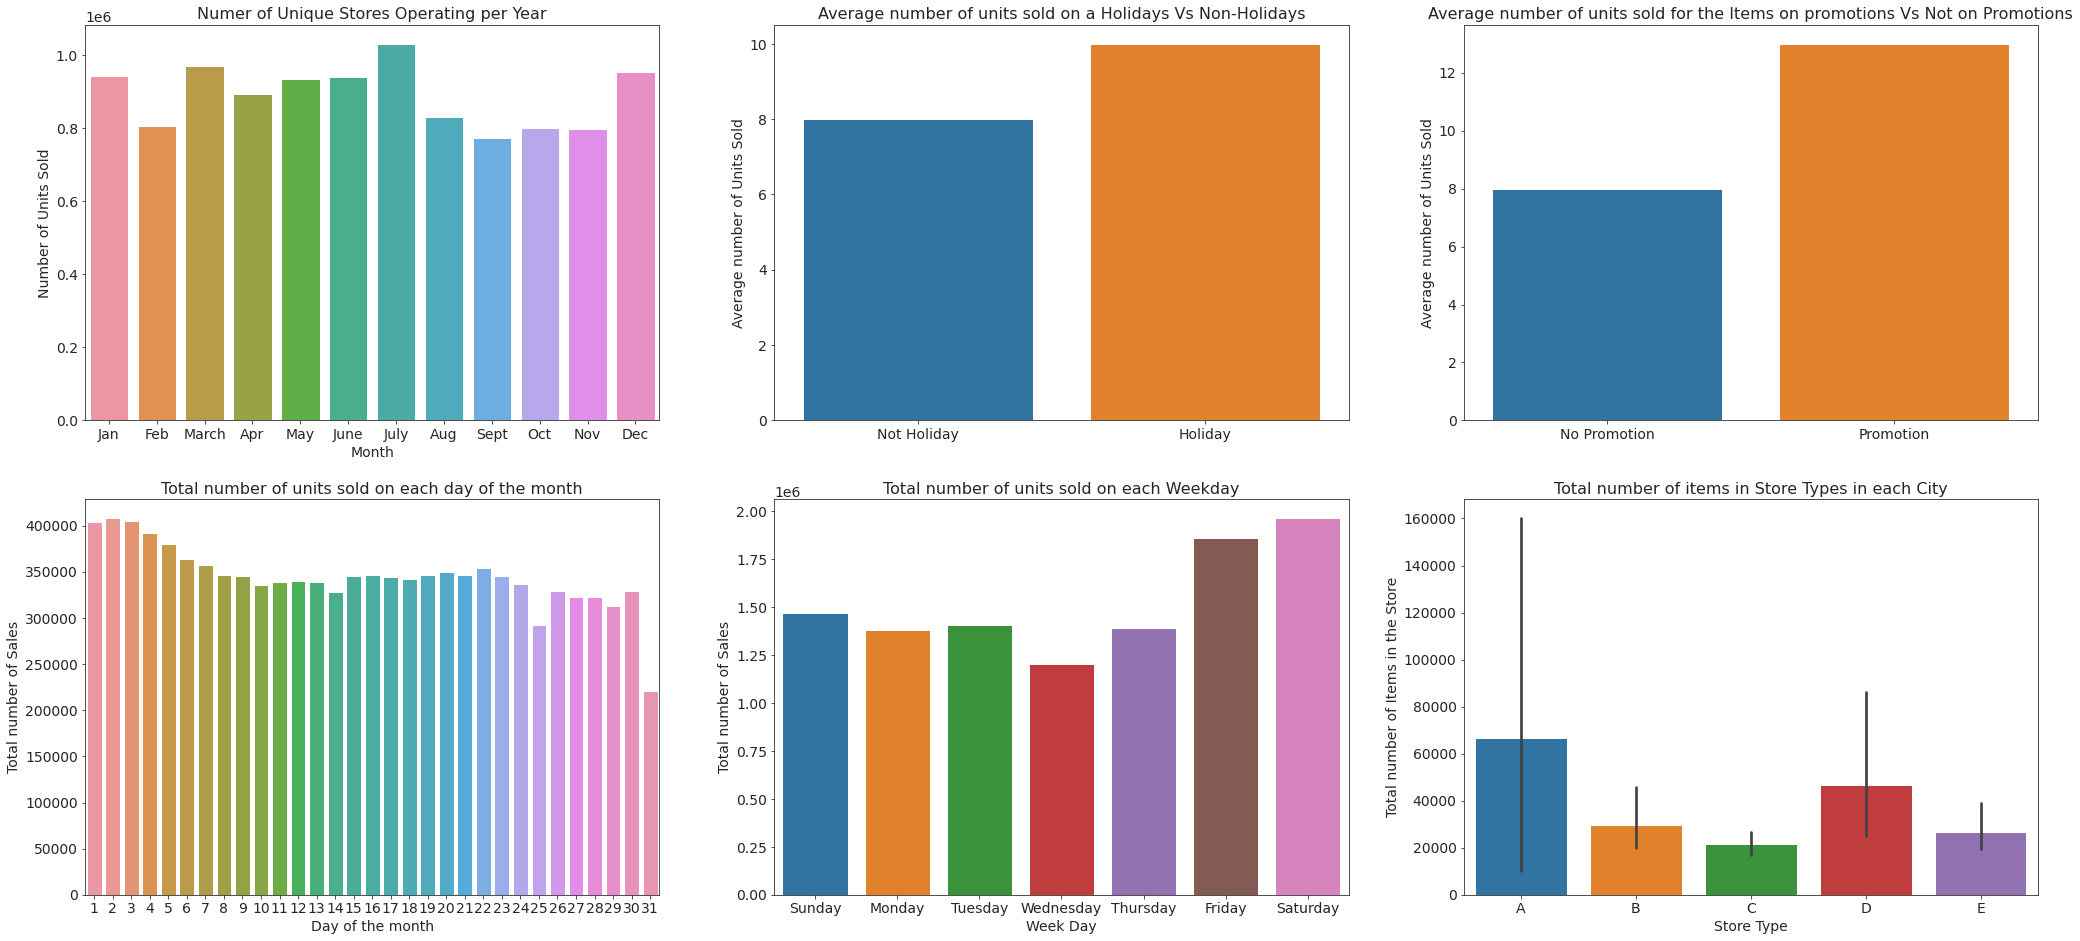

In [ ]:
fig1, axes1 = plt.subplots(2,3,  figsize=(35, 16))

axes1[0,0].set_title('Numer of Unique Stores Operating per Year',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=monthly_df.month,y=monthly_df.unit_sales,ax=axes1[0,0])
axes1[0,0].set_xlabel("Month")
axes1[0,0].set_ylabel("Number of Units Sold");


axes1[0,1].set_title('Average number of units sold on a Holidays Vs Non-Holidays',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=isHoliday_df.isHoliday,y=isHoliday_df.unit_sales,ax=axes1[0,1])
axes1[0,1].set_xlabel(" ")
axes1[0,1].set_ylabel("Average number of Units Sold");

axes1[0,2].set_title('Average number of units sold for the Items on promotions Vs Not on Promotions',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=onPromotion_df.onpromotion,y=onPromotion_df.unit_sales,ax=axes1[0,2])
axes1[0,2].set_xlabel(" ")
axes1[0,2].set_ylabel("Average number of Units Sold");


axes1[1,0].set_title('Total number of units sold on each day of the month',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=day_df.day,y=day_df.unit_sales,ax=axes1[1,0])
axes1[1,0].set_xlabel("Day of the month")
axes1[1,0].set_ylabel("Total number of Sales");

axes1[1,1].set_title('Total number of units sold on each Weekday',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=weekday_df.weekday,y=weekday_df.unit_sales,ax=axes1[1,1])
axes1[1,1].set_xlabel("Week Day")
axes1[1,1].set_ylabel("Total number of Sales");

axes1[1,2].set_title('Total number of items in Store Types in each City',fontsize=16)
colors = sns.color_palette('pastel')[0:5]
sns.barplot(x=store_types_df.store_type,y=store_types_df.item_nbr, ax=axes1[1,2])
axes1[1,2].set_xlabel("Store Type")
axes1[1,2].set_ylabel("Total number of Items in the Store");


Observation:
* Sale higest during the month of July presumably because of summer holidays.
* There is a 14% increase in sales on Holidays.
* There is a 50% increase in sales of the items on promotion.
* Sales are higher first 4 days of the month presumably because of payday.
* There is a 30%  increase in sales on Fridays and Saturdays (weekends).
* Store A is a bigger sores with more number of items in that store, hence more sales.

In [ ]:
family_sales_df=items_df[['family','item_nbr']].groupby('family').count().reset_index()

In [ ]:
fig2=px.bar(family_sales_df,x=family_sales_df.family,y=family_sales_df.item_nbr)
fig2.update_layout(
    title="Product Family Sales",
    xaxis_title="Family",
    yaxis_title="Units Sold",
    plot_bgcolor='#ffcc9c',

)

Grocery I is the highest Selling items and also number of distict items.

In [ ]:
store_item_45_df=ml_train_df.loc[(ml_train_df.store_nbr==45) & (ml_train_df.item_nbr.isin([273528,759893,841842,559870]))][['date','item_nbr','family','unit_sales']].sort_values('date')
store_item_44_df=ml_train_df.loc[(ml_train_df.store_nbr==44) & (ml_train_df.item_nbr.isin([273528,759893,841842,559870]))][['date','item_nbr','family','unit_sales']].sort_values('date')


In [ ]:
items_df.loc[items_df.item_nbr.isin([273528,759893,841842,559870])]

,item_nbr,family,class,perishable
259,273528,PERSONAL CARE,4114,0
659,559870,GROCERY I,1072,0
937,759893,CLEANING,3032,0
1090,841842,GROCERY I,1072,0


In [ ]:
px.line(store_item_44_df,x='date',y='unit_sales',color='item_nbr',hover_data=['family','date'] ,title='Trend over the years of Top 5 Items unit sold in Store 44  ')


In [ ]:
px.line(store_item_45_df,x='date',y='unit_sales',color='item_nbr',hover_data=['family','date'] ,title='Trend over the years of Top 5 Items unit sold in Store 45  ')

Observation:
Personal Care and Cleaning products are trending lower , while Grocery I is showing erractic trend.

## Machine Learning

####  Prepare data for ML Models.

Read the saved Feature Engineered Train & Test dataset with `weight` columns.

In [ ]:
mlw_train_df=pd.read_parquet('ml_train_df.parquet')
mlw_test_df=pd.read_parquet('ml_test_df.parquet')

In [ ]:
mlw_train_df.onpromotion=mlw_train_df.onpromotion.astype('int8')
mlw_test_df.onpromotion=mlw_test_df.onpromotion.astype('int8')

In [ ]:
input_cols=['date_ord', 'store_nbr', 'item_nbr', 'onpromotion',  'dcoilwtico', 'transactions', 'isHoliday', 'holiday_type','day', 'weekday', 'month', 'year', 'isWeekend', 'payday', 'weight']
target_cols=['unit_sales']

Get a top 15 Correlation Co-eff of various columns with `unit_sales`

In [ ]:
%%time
mlw_train_df.corr().sort_values('unit_sales',ascending=False)['unit_sales'].head(15)

CPU times: user 999 ms, sys: 78.9 ms, total: 1.08 s
Wall time: 1.07 s


unit_sales      1.000000
transactions    0.186226
weight          0.070703
onpromotion     0.068563
isWeekend       0.056439
store_nbr       0.055545
weekday         0.041784
item_nbr        0.021849
payday          0.021719
isHoliday       0.017282
dcoilwtico      0.013800
month           0.010452
day            -0.014785
date_ord       -0.016254
id             -0.017101
Name: unit_sales, dtype: float64

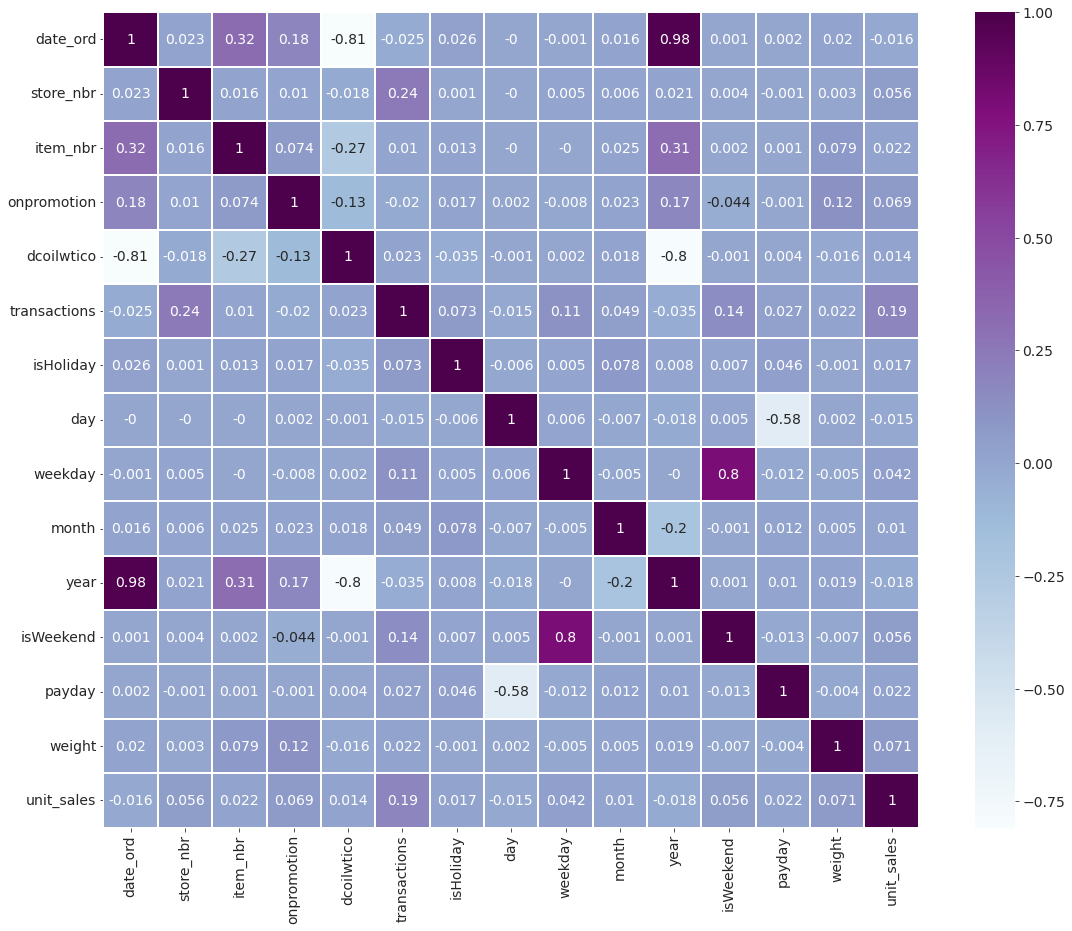

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(mlw_train_df[input_cols+target_cols].corr().round(3), annot=True, cmap='BuPu', square=True, linewidths=1);

We can see there is some correlation between the input features.(date_ord,year),(perishable,weight),(weekday,isWeekend),(year,dcoilwtico). We will eliminate some of these columns from the model input.

In [ ]:
input_cols=['date_ord', 'store_nbr', 'item_nbr', 'onpromotion','isHoliday', 'weekday','day', 'holiday_type','month', 'isWeekend', 'payday', 'weight', 'dcoilwtico']
target_cols=['unit_sales']

Make a copy of dataset with addition of `weight` column.

In [ ]:
SAMPLE_SIZE=1000_000
mlw_train_df= mlw_train_df.sample(SAMPLE_SIZE, random_state=42).copy(deep=True)

In [ ]:
ml_train_df=mlw_train_df[input_cols].copy(deep=True)
ml_train_tget_df=mlw_train_df[target_cols].copy(deep=True)

ml_test_df=mlw_test_df[input_cols].copy(deep=True)


Add another target_column with a log value of the `unit_sales`.
Convert the target column unit_sales as log(e).

In [ ]:
ml_train_tget_df['ln_unit_sales']=np.log(ml_train_tget_df.unit_sales+1)

#### Prepare Data to feed ML model as input varaibles.

Dealing with Categorical columns using.

Get number of unique values in each of the categorical values

In [ ]:
ml_train_df.nunique()

date_ord        1684
store_nbr         54
item_nbr        4007
onpromotion        2
isHoliday          2
weekday            7
day               31
holiday_type       7
month             12
isWeekend          2
payday             2
weight             2
dcoilwtico       994
dtype: int64

 **OneHotEncoding**

Perform oneHotEncoding on categorical columns that has more than two unique values.

In [ ]:
cat_ohe_cols=[ 'holiday_type']

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def do_oneHotEncode(df,ohe_list):
  
  for col in ohe_list:
    #Encode column values
    col_encode= OneHotEncoder(sparse=False,handle_unknown='ignore').fit(ml_train_df[[col]])
    #Generate Columns for the encoded column
    col_encode_cols=list(col_encode.get_feature_names_out([col]))
    #Generate encoded values
    df[col_encode_cols]=col_encode.transform(df[[col]]).astype('int8')

Perform oneHotEncoding on categorical columns on ML Testing Dataset.

In [ ]:
do_oneHotEncode(ml_train_df,cat_ohe_cols)

In [ ]:
do_oneHotEncode(ml_test_df,cat_ohe_cols)

**MeanTargetEncoding**

For the Categorical columns that has more than 50 unique values. class,item_nbr and store_nbr Encode the columns using Mean TargetEncoder.

In [ ]:
cat_mte_cols=[ ]
from category_encoders import TargetEncoder
mte=TargetEncoder()
mte_cols=[x+'_mte' for x in cat_mte_cols]
ml_train_df[mte_cols]=mte.fit_transform(X=ml_train_df[cat_mte_cols].astype('str'), y=ml_train_tget_df[target_cols])
ml_test_df[mte_cols]=mte.transform(X=ml_test_df[cat_mte_cols])

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


**Scaling**  
We will use MinMax Scaler, this is used to transform numeric columns values in each column in the range of 0 and 1 for input dataset.

In [ ]:
num_cols=[]
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def scale_data_input_data(df,num_cols):
  input_scaler=MinMaxScaler(feature_range=(0,1))
  #scaler=StandardScaler()
  df[num_cols]=input_scaler.fit_transform(df[num_cols])

In [ ]:
#Scale Numeric columns of Training dataset
##scale_data_input_data(ml_train_df,num_cols)
#Scale Numeric columns of Training dataset 
##input_test_scaler=scale_data_input_data(ml_test_df,num_cols)

Drop redundant categorical columns that are replaced by encoded columns.

In [ ]:
#Drop redundant categorical columns(cat_mte_cols,cat_ohe_cols) replaced by encoded columns
ml_train_df.drop(cat_ohe_cols+cat_mte_cols, axis=1, inplace=True)
ml_test_df.drop(cat_ohe_cols+cat_mte_cols, axis=1, inplace=True)

### Try ML Models and Evaluate them.  


#### Create Three **Helper functions**:
Function to Evaluate Metrics.  
Function to make Predictions for given Model.  
Function to make Predictions of Test datasets and Submit it to Kaggle.


Function to **Evaluate Merics:**
Lets define evaluation metric and loss function we will use:
 Normalized Weighted Root Mean Squared Logarithmic Error.



In [ ]:
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error
from math import sqrt
def evaluation_metrics_val(preditions):
  #Validation Predictions Error
  n_v=np.sum(input_val_data_df['weight']*(preditions-target_val_df)**2)
  d_v=np.sum(input_val_data_df['weight'])
  v_NWRMSLE=round(sqrt(n_v/d_v),4)
  v_rmse=mean_squared_error(target_val_df, preditions,squared=False,sample_weight=input_val_data_df.weight)
  v_rmsle=mean_squared_log_error(target_val_df, preditions,squared=False,sample_weight=input_val_data_df.weight)

  return v_NWRMSLE,v_rmse,v_rmsle

def evaluation_metrics_train(preditions):
  #Training Predictions Error
  n_t=np.sum(input_training_df['weight']*(preditions-target_training_df)**2)
  d_t=np.sum(input_training_df['weight'])
  t_NWRMSLE=round(sqrt(n_t/d_t),4)
  t_rmse=mean_squared_error(target_training_df, preditions,squared=False,sample_weight=input_training_df.weight)
  t_rmsle= mean_squared_log_error(target_training_df, preditions,squared=False,sample_weight=input_training_df.weight)

  return t_NWRMSLE,t_rmse,t_rmsle


Function to  **Create Model and Check Performance.**  

In [ ]:
def checkModelPerformance(model):
  #Fit training data to create Model
  
  #model.fit(input_training_df,y=target_training_df.values.ravel())
  model.fit(input_training_df,y=target_training_df.values.ravel(),sample_weight=input_training_df.weight)
  
  #Predict unit sales for Training Data
  training_data_preditions= model.predict(input_training_df)
  #Predict unit sales for Testing Data
  val_data_preditions= model.predict(input_val_data_df)
  
  model_name=type(model).__name__

  training_data_preditions=np.clip(training_data_preditions,.00001,6000)
  val_data_preditions=np.clip(val_data_preditions,.00001,6000)

  v_NWRMSLE,v_rmse,v_rmsle=evaluation_metrics_val(val_data_preditions)
  t_NWRMSLE,t_rmse,t_rmsle=evaluation_metrics_train(training_data_preditions)

  print("Training mean_squared_error for      {}: {} ".format(model_name,t_rmse))
  print("Training NWRMSLE for                  {}: {} ".format(model_name,t_NWRMSLE))
  print("Training mean_squared_log_error for  {}: {} ".format(model_name,t_rmsle))
  print("=======")
 
  print("Validation mean_squared_error for     {}: {} ".format(model_name, v_rmse))
  print("Validation NWRMSLE for                 {}: {} ".format(model_name,v_NWRMSLE))
  print("Validation mean_squared_log_error for {}: {} ".format(model_name, v_rmsle))
  
 
  return(model,model_name,v_NWRMSLE,v_rmse,v_rmsle)

Function to **predict and create csv file** for Kaggle submission.

In [ ]:
def predict_and_submit_test_dataset(model,file_name):
  #Make Predictions for the Test Dataset
  preds=model.predict(ml_test_df)
  predictions=np.exp(preds)-1
  #predictions=preds

  submission_df=pd.read_csv('sample_submission.csv')
  
  submission_df['unit_sales']=predictions
  submission_df.loc[submission_df.unit_sales<0,'unit_sales']=0.0001
  print("Number of predictions to be made    : ",len(submission_df))
  print("Number of predictions actually made : ",len(predictions))

  submission_df.to_csv(file_name+'.zip',index=None,compression="zip")

**Evaluate** the following models.  
Linear Models:  
* Linear
* Ridge
* Lasso
* ElasticNet  

Tree Based Models:  
* Decision Tree
* Random Forest
* BaggingRegressor
* XGBoost  
* LGBMRegressor

Combine Tree Models:
* AdaBoostRegressor
* StackingRegressor


Create Training and Validation Datasets.

In [ ]:
from sklearn.model_selection import train_test_split

input_training_df, input_val_data_df, target_training_df, target_val_df = train_test_split(ml_train_df, ml_train_tget_df['ln_unit_sales'], test_size=0.3,random_state=42,shuffle=False)

In [ ]:
input_training_df.head(5)

,date_ord,store_nbr,item_nbr,onpromotion,isHoliday,weekday,day,month,isWeekend,payday,weight,dcoilwtico,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,holiday_type_noholiday
641804,735940,39,1673297,1,0.0,1,8,12,0,0,1.25,37.46,0,0,0,0,0,0,1
758066,736064,49,940664,0,0.0,6,10,4,1,0,1.00,39.74,0,0,0,0,0,0,1
1138966,736449,41,2046670,0,0.0,6,30,4,1,0,1.00,49.31,0,0,0,0,0,0,1
131996,735172,9,847859,0,0.0,3,31,10,0,0,1.00,96.29,0,0,0,0,0,0,1
725315,736030,31,749421,0,0.0,0,7,3,0,0,1.00,37.90,0,0,0,0,0,0,1


Sample Distribution of unit_sales.

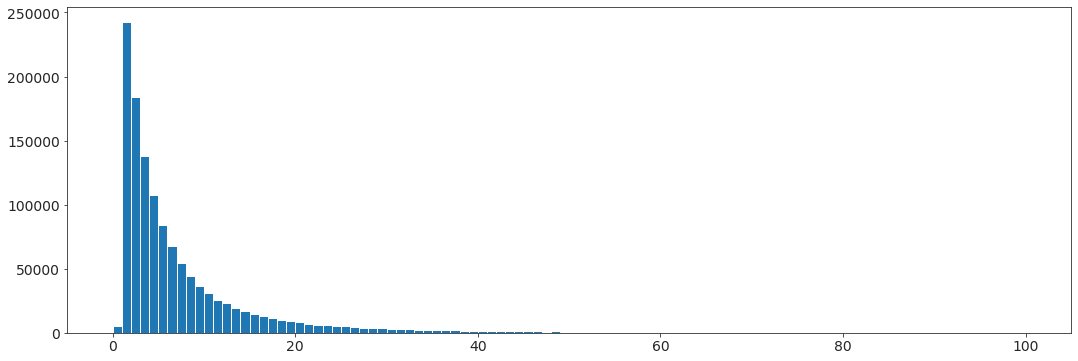

In [ ]:
plt.hist(ml_train_tget_df['unit_sales'], bins=100,range=(0,100));

Majority of the units sold are in between 1-3. The unit sales reduces exponentially.

In [ ]:
#Dictionary to record the models ans its error on the validation sets.
model_names_list=[]
model_error_list=[]
def record_model_error(model_name,v_error):
  model_names_list.append(model_name)
  model_error_list.append(v_error)


**Base Model.** Predicts `unit_sales` as a all of Dataset's Mean.

In [ ]:
class MeanRegressor():
  '''
   Calculate mean of all the unit_sales and make the same as predictions
  '''
  def fit(self,inputs,targets):
    self.mean=targets.mean()

  def predict(self, inputs):
    return np.full(inputs.shape[0],self.mean)
  

In [ ]:
BaseModel=MeanRegressor()

In [ ]:
BaseModel.fit(input_training_df,target_training_df)

In [ ]:
#Predict Training data
train_preds=BaseModel.predict(target_training_df)

In [ ]:
print("NWRMSLE for Baseline(Mean) Training data predictions :",mean_squared_error(target_training_df, train_preds,squared=False,sample_weight=input_training_df.weight))

NWRMSLE for Baseline(Mean) Training data predictions : 0.8870551335289831


In [ ]:
#Predict Validation data
val_preds=BaseModel.predict(target_val_df)

In [ ]:
print("NWRMSLE for Baseline(Mean) Validation data predictions :",mean_squared_error(target_val_df, val_preds,squared=False,sample_weight=input_val_data_df.weight))

NWRMSLE for Baseline(Mean) Validation data predictions : 0.8810685733063937


In [ ]:
record_model_error('BaseModel',0.8704)

#### Now lets try different Models.

#### Linear Models

**Linear Regression**

In [ ]:
%%time
from sklearn.linear_model import LinearRegression
linRegModel,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(LinearRegression())
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      LinearRegression: 0.869387396722961 
Training NWRMSLE for                  LinearRegression: 0.8694 
Training mean_squared_log_error for  LinearRegression: 0.307681808363718 
Validation mean_squared_error for     LinearRegression: 0.857084553787635 
Validation NWRMSLE for                 LinearRegression: 0.8571 
Validation mean_squared_log_error for LinearRegression: 0.3071724353416994 
CPU times: user 1.48 s, sys: 1.8 s, total: 3.27 s
Wall time: 1.1 s


In [ ]:
predict_and_submit_test_dataset(linRegModel,'lin_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**Ridge Regression**

In [ ]:
%%time
from sklearn.linear_model import Ridge
ridgeRegModel=Ridge()
ridgeRegModel,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(ridgeRegModel)
record_model_error(model_name,v_NWRMSLE)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning:

Ill-conditioned matrix (rcond=3.22148e-18): result may not be accurate.



Training mean_squared_error for      Ridge: 0.8693873967788334 
Training NWRMSLE for                  Ridge: 0.8694 
Training mean_squared_log_error for  Ridge: 0.3076818256920473 
Validation mean_squared_error for     Ridge: 0.8570846420286503 
Validation NWRMSLE for                 Ridge: 0.8571 
Validation mean_squared_log_error for Ridge: 0.30717247421565325 
CPU times: user 774 ms, sys: 1.26 s, total: 2.04 s
Wall time: 563 ms


In [ ]:
predict_and_submit_test_dataset(ridgeRegModel,'ridge_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**Lasso Rigression**

In [ ]:
%%time
print("Lasso regression ")
from sklearn.linear_model import Lasso
lassoRegModel=Lasso(alpha=0.5)
lassoRegModel,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(lassoRegModel)
record_model_error(model_name,v_NWRMSLE)

Lasso regression 
Training mean_squared_error for      Lasso: 0.8838076355445309 
Training NWRMSLE for                  Lasso: 0.8838 
Training mean_squared_log_error for  Lasso: 0.3127395709634296 
Validation mean_squared_error for     Lasso: 0.8768423482033231 
Validation NWRMSLE for                 Lasso: 0.8768 
Validation mean_squared_log_error for Lasso: 0.31392835373738215 
CPU times: user 1.12 s, sys: 1.57 s, total: 2.7 s
Wall time: 832 ms


In [ ]:
predict_and_submit_test_dataset(lassoRegModel,'lasso_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**ElasticNet Regression**

In [ ]:
%%time
print("ElasticNet regression ")
from sklearn.linear_model import ElasticNet
ElasticNetModel,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(ElasticNet())
record_model_error(model_name,v_NWRMSLE)

ElasticNet regression 
Training mean_squared_error for      ElasticNet: 0.8838103082588656 
Training NWRMSLE for                  ElasticNet: 0.8838 
Training mean_squared_log_error for  ElasticNet: 0.31274038831342665 
Validation mean_squared_error for     ElasticNet: 0.876845348655017 
Validation NWRMSLE for                 ElasticNet: 0.8768 
Validation mean_squared_log_error for ElasticNet: 0.31392931669102153 
CPU times: user 1.11 s, sys: 1.19 s, total: 2.31 s
Wall time: 709 ms


In [ ]:
predict_and_submit_test_dataset(ElasticNetModel,'elasticNet_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


#### Decision Tree Models

**Decision Tree**

In [ ]:
%%time
#from pandas.core.common import random_state
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=42)
dtr,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(dtr)
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      DecisionTreeRegressor: 0.0 
Training NWRMSLE for                  DecisionTreeRegressor: 0.0 
Training mean_squared_log_error for  DecisionTreeRegressor: 2.7431347242484933e-08 
Validation mean_squared_error for     DecisionTreeRegressor: 1.0458471755064898 
Validation NWRMSLE for                 DecisionTreeRegressor: 1.0458 
Validation mean_squared_log_error for DecisionTreeRegressor: 0.37697440254205394 
CPU times: user 11.6 s, sys: 24.9 ms, total: 11.6 s
Wall time: 11.5 s


In [ ]:
predict_and_submit_test_dataset(dtr,'dtr_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**Random Forest**

In [ ]:
%%time
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)
rfr,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(rfr)
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      RandomForestRegressor: 0.2596458904728758 
Training NWRMSLE for                  RandomForestRegressor: 0.2596 
Training mean_squared_log_error for  RandomForestRegressor: 0.10036930899506818 
Validation mean_squared_error for     RandomForestRegressor: 0.737031714924829 
Validation NWRMSLE for                 RandomForestRegressor: 0.737 
Validation mean_squared_log_error for RandomForestRegressor: 0.27221124174243877 
CPU times: user 17min 52s, sys: 15.4 s, total: 18min 7s
Wall time: 2min 24s


In [ ]:
predict_and_submit_test_dataset(rfr,'rfr_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**BaggingRegressor**

In [ ]:
%%time
from sklearn.ensemble import BaggingRegressor
br = BaggingRegressor(random_state=42, n_jobs=-1)
br,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(rfr)
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      RandomForestRegressor: 0.2596458904728758 
Training NWRMSLE for                  RandomForestRegressor: 0.2596 
Training mean_squared_log_error for  RandomForestRegressor: 0.10036930899506818 
Validation mean_squared_error for     RandomForestRegressor: 0.737031714924829 
Validation NWRMSLE for                 RandomForestRegressor: 0.737 
Validation mean_squared_log_error for RandomForestRegressor: 0.27221124174243877 
CPU times: user 17min 47s, sys: 2.77 s, total: 17min 50s
Wall time: 2min 20s


In [ ]:
predict_and_submit_test_dataset(br,'br_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**XGBoost**

In [ ]:
%%time
from xgboost import XGBRegressor
xgb=XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squaredlogerror',eval_metric='rmsle')
xgb,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(xgb)
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      XGBRegressor: 0.7257282681750384 
Training NWRMSLE for                  XGBRegressor: 0.7257 
Training mean_squared_log_error for  XGBRegressor: 0.25367193010176214 
Validation mean_squared_error for     XGBRegressor: 0.7446945359716572 
Validation NWRMSLE for                 XGBRegressor: 0.7447 
Validation mean_squared_log_error for XGBRegressor: 0.26270367064612826 
CPU times: user 3min 32s, sys: 175 ms, total: 3min 32s
Wall time: 27.4 s


In [ ]:
predict_and_submit_test_dataset(xgb,'xgb_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**lightGBM**

In [ ]:
%%time
import lightgbm as lgbm
lgb=lgbm.LGBMRegressor(random_state=42, n_jobs=-1 )
lgb,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(lgb)
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      LGBMRegressor: 0.7878868147066505 
Training NWRMSLE for                  LGBMRegressor: 0.7879 
Training mean_squared_log_error for  LGBMRegressor: 0.2808220873357903 
Validation mean_squared_error for     LGBMRegressor: 0.7853805733925275 
Validation NWRMSLE for                 LGBMRegressor: 0.7854 
Validation mean_squared_log_error for LGBMRegressor: 0.282961494285997 
CPU times: user 24.7 s, sys: 67.4 ms, total: 24.7 s
Wall time: 3.44 s


In [ ]:
predict_and_submit_test_dataset(lgb,'lgb_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


Combining Tree Models.

**AdaBoostRegressor**(Boosting)

In [ ]:
%%time
from sklearn.ensemble import AdaBoostRegressor
abr =AdaBoostRegressor(RandomForestRegressor(random_state=42, n_jobs=-1),learning_rate=0.1 ,n_estimators=5)
abr,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(abr)
record_model_error(model_name,v_NWRMSLE)

Training mean_squared_error for      AdaBoostRegressor: 0.36787456471331187 
Training NWRMSLE for                  AdaBoostRegressor: 0.3679 
Training mean_squared_log_error for  AdaBoostRegressor: 0.13857628957231646 
Validation mean_squared_error for     AdaBoostRegressor: 0.7422045716773684 
Validation NWRMSLE for                 AdaBoostRegressor: 0.7422 
Validation mean_squared_log_error for AdaBoostRegressor: 0.273539307240256 
CPU times: user 1h 54min 52s, sys: 1min 20s, total: 1h 56min 12s
Wall time: 15min 20s


In [ ]:
predict_and_submit_test_dataset(abr,'abr_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


**StackingRegressor**(Stacking Ensembling all Tree models)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgbm

from mlxtend.regressor import StackingRegressor
dtr = DecisionTreeRegressor(random_state=42)
lgb=lgbm.LGBMRegressor(random_state=42, n_jobs=-1 ,eval_metric='rmsle')
xgb=XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squaredlogerror',eval_metric='rmsle')
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_meta=XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squaredlogerror',eval_metric='rmsle')
stgr = StackingRegressor(regressors=[xgb, lgb, rfr], meta_regressor=dtr )
stgr,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(stgr)
record_model_error(model_name,v_NWRMSLE)

[LightGBM] [Warning] Unknown parameter: eval_metric
Training mean_squared_error for      StackingRegressor: 0.0 
Training NWRMSLE for                  StackingRegressor: 0.0 
Training mean_squared_log_error for  StackingRegressor: 2.7431347242484933e-08 
Validation mean_squared_error for     StackingRegressor: 0.7919308518484738 
Validation NWRMSLE for                 StackingRegressor: 0.7919 
Validation mean_squared_log_error for StackingRegressor: 0.29215634927197914 


In [ ]:
predict_and_submit_test_dataset(stgr,'stgr_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


Create DataFrame with model name and its Validation predictions Error.

In [ ]:
model_error_df=pd.DataFrame({'model_name':model_names_list,'val_error':model_error_list})

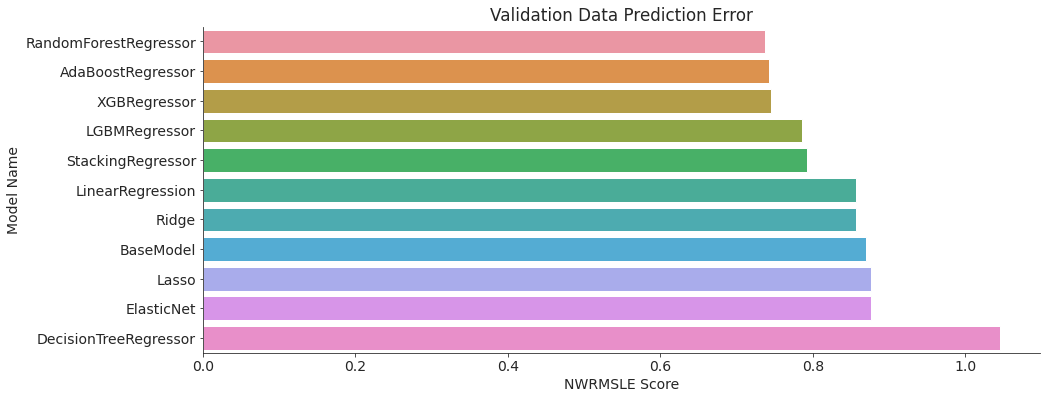

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(data=model_error_df.sort_values('val_error'), y='model_name', x='val_error' )
plt.xlabel('NWRMSLE Score')
plt.ylabel('Model Name')
plt.title('Validation Data Prediction Error')
sns.despine();

In [ ]:
k_model_name=['abr','br','dtr','elasticnet','lasso','lgb','lin','rfr','ridge','stgr','xgb']
kaggle_score_lst=[1.25216,1.36482,1.42631,1.36033,1.36032,1.246,1.32709,1.24813,1.32709,1.29068,1.12965]
model_kaggle_score_df=pd.DataFrame({'model_name':k_model_name,'kaggle_score':kaggle_score_lst})

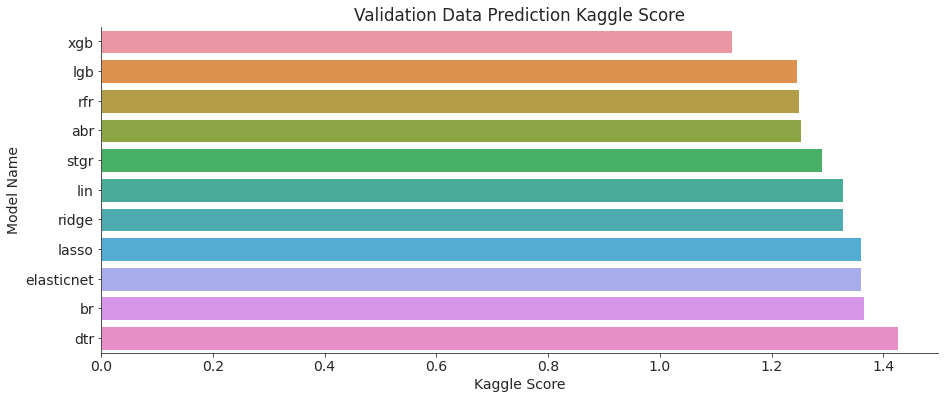

In [ ]:
plt.figure(figsize=(15,6))
sns.barplot(data=model_kaggle_score_df.sort_values('kaggle_score'), y='model_name', x='kaggle_score' )
plt.xlabel('Kaggle Score')
plt.ylabel('Model Name')
plt.title('Validation Data Prediction Kaggle Score')
sns.despine();

Feature Importance.  

In [ ]:
def plot_feature_importance(features, importance, model_name):

  importance_df = pd.DataFrame({
                              'features': features,
                              'importance': importance
                              }).sort_values(by = 'importance', ascending= False)
  #print(importance_df.head(10))
  plt.figure(figsize=(10,6))
  plt.title(model_name + ' Feature Importance')
  sns.barplot(data=importance_df.head(10), x='importance', y='features')
  sns.despine();

  return

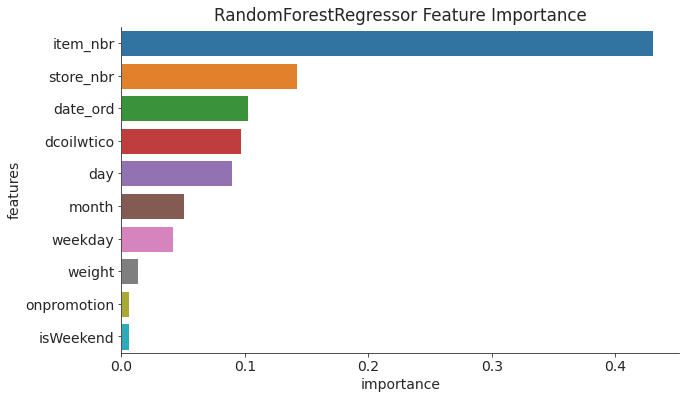

In [ ]:
rfr.fit(input_training_df,target_training_df)
plot_feature_importance(input_training_df.columns,rfr.feature_importances_,type(rfr).__name__)

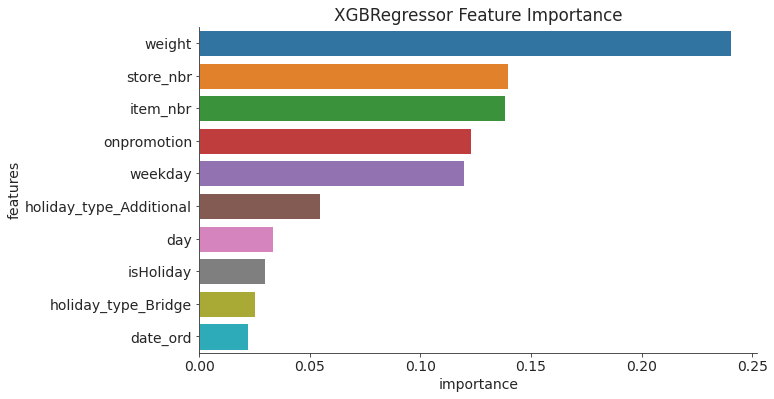

In [ ]:
xgbf.fit(input_training_df,target_training_df)
plot_feature_importance(input_training_df.columns,xgb.feature_importances_,type(xgb).__name__)

In [ ]:
lgb.fit(input_training_df,target_training_df)
plot_feature_importance(input_training_df.columns,lgb.feature_importances_,type(lgb).__name__)

### Model Selection  
Based on the Model's Performance , Looks like `RandomForest` has the least NWRMSLE & `XGBoost` has the least Kaggle score. We will tune the Hyper parameters of these models.

###  XGBRegressor

In [ ]:
from xgboost import XGBRegressor
def tune_hyperParams( param_val,**params):
  model=XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squaredlogerror',eval_metric='rmsle', **params )
  model.fit(input_training_df, target_training_df)
  train_preds=model.predict(input_training_df)
  val_preds=model.predict(input_val_data_df)

  train_preds=np.clip(train_preds,0.00001,10000)
  val_preds=np.clip( val_preds,0.00001,10000)

  train_err=evaluation_metrics_train(train_preds)
  val_err=evaluation_metrics_val(val_preds)

  return { 'param_value':param_val, 'Training Error': train_err[0], 'Validation Error': val_err[0]}

In [ ]:
def plot_fitting_curve(param_name,errors_df,x,y,i):
  plt.figure()
  plt.plot(errors_df['param_value'], errors_df['Training Error'])
  plt.plot(errors_df['param_value'], errors_df['Validation Error'])
  plt.title(param_name+': Training vs. Validation Error')
  plt.xticks(range(x,y, i))
  plt.xlabel(param_name)
  plt.ylabel('Prediction Error')
  plt.legend(['Training', 'Validation'])

In [ ]:
%%time
est_error_df=pd.DataFrame([tune_hyperParams(x, n_estimators=x) for x in range(10,500,50)])

CPU times: user 1h 26min 4s, sys: 3.56 s, total: 1h 26min 7s
Wall time: 10min 54s


In [ ]:
est_error_df.sort_values('Validation Error').head(5)

,param_value,Training Error,Validation Error
9,460,0.6295,0.6850
8,410,0.6362,0.6884
7,360,0.6451,0.6931
6,310,0.6547,0.6987
5,260,0.6647,0.7037


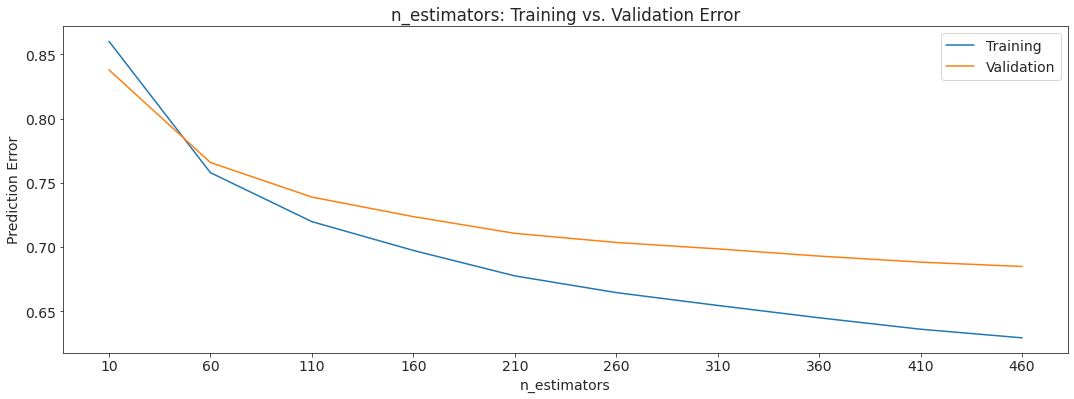

In [ ]:
plot_fitting_curve('n_estimators',est_error_df,10,500,50)

In [ ]:
%%time
mdepth_error_df=pd.DataFrame([tune_hyperParams(x,n_estimators=500, max_depth=x) for x in range(2,22,4)])

CPU times: user 2h 41min 19s, sys: 19.9 s, total: 2h 41min 39s
Wall time: 20min 27s


In [ ]:
mdepth_error_df.sort_values('Validation Error').head(5)

,param_value,Training Error,Validation Error
2,10,0.5106,0.6742
1,6,0.6241,0.6825
3,14,0.3816,0.6872
4,18,0.2652,0.6945
0,2,0.7660,0.7647


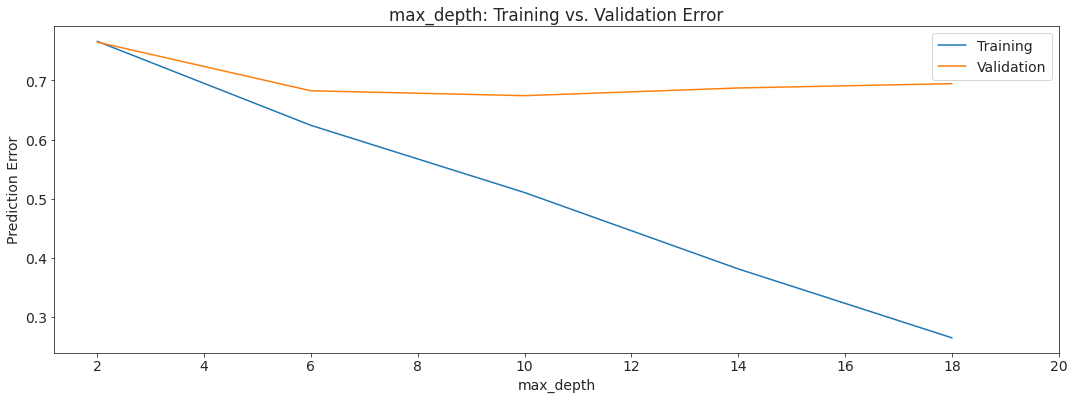

In [ ]:
plot_fitting_curve('max_depth',mdepth_error_df,2,22,2)

In [ ]:
%%time
error_df=pd.DataFrame([tune_hyperParams(x,n_estimators=500, max_depth=10,learning_rate=x/100) for x in range(5,50,5)])

CPU times: user 4h 26min, sys: 17.8 s, total: 4h 26min 18s
Wall time: 33min 49s


In [ ]:
error_df.sort_values('Validation Error').head(5)

,param_value,Training Error,Validation Error
7,40,0.8295,0.8460
6,35,0.8406,0.8473
8,45,0.8220,0.8533
5,30,0.8569,0.8537
4,25,0.8863,0.8690


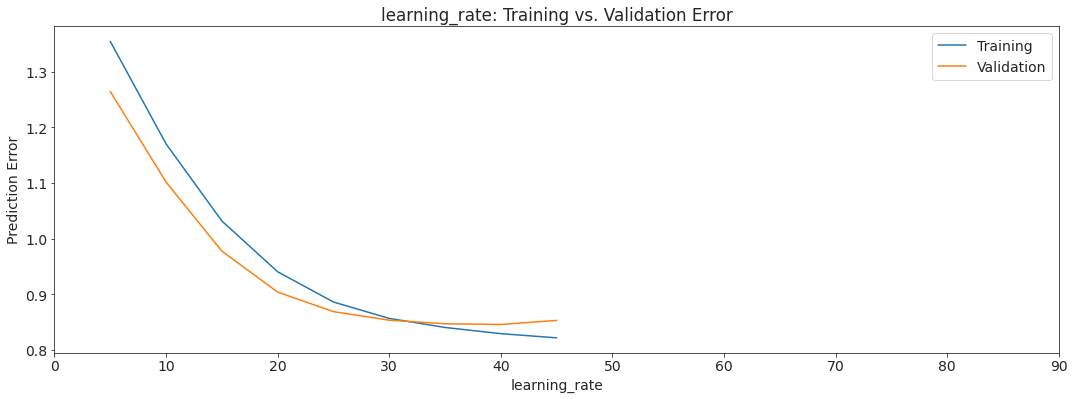

In [ ]:
plot_fitting_curve('learning_rate',error_df,0,100,10)

In [ ]:
subsamp_error_df.sort_values('Validation Error').head(5)

,param_value,Training Error,Validation Error
4,90,0.5113,0.6879
3,70,0.5216,0.7010
2,50,0.5407,0.7265
1,30,0.5719,0.7837
0,10,0.6590,1.0583


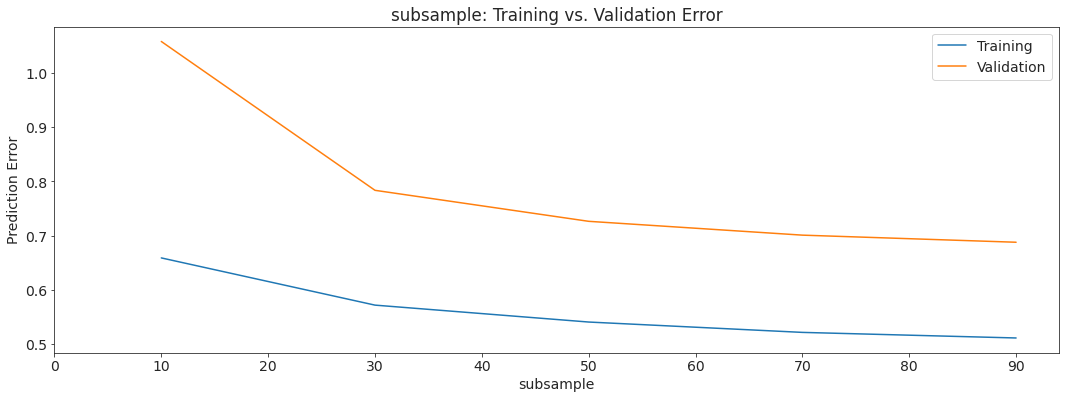

In [ ]:
plot_fitting_curve('subsample',subsamp_error_df,0,100,10)


In [ ]:
%%time
cs_error_df=pd.DataFrame([tune_hyperParams(x,n_estimators=500, max_depth=10,colsample_bytree=x/100) for x in range(10,100,20)])

CPU times: user 1h 38min 23s, sys: 6.85 s, total: 1h 38min 30s
Wall time: 12min 30s


In [ ]:
cs_error_df

,param_value,Training Error,Validation Error
0,10,0.7107,0.7247
1,30,0.6144,0.6769
2,50,0.5690,0.6757
3,70,0.5362,0.6678
4,90,0.5168,0.6737


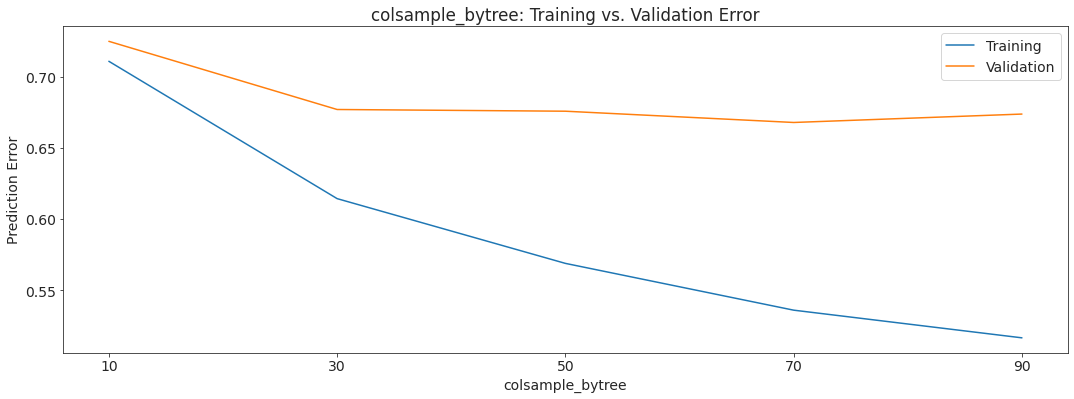

In [ ]:
plot_fitting_curve('colsample_bytree',cs_error_df,10,100,20)

###RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def tune_hyperParams_lgbm( param_val,**params):
  model=RandomForestRegressor(random_state=42, n_jobs=-1, **params )
  model.fit(input_training_df, target_training_df)
  train_preds=model.predict(input_training_df)
  val_preds=model.predict(input_val_data_df)

  train_preds=np.clip(train_preds,0.00001,10000)
  val_preds=np.clip( val_preds,0.00001,10000)

  train_err=evaluation_metrics_train(train_preds)
  val_err=evaluation_metrics_val(val_preds)

  return { 'param_value':param_val, 'Training Error': train_err[0], 'Validation Error': val_err[0]}

In [ ]:
%%time
est_error_df=pd.DataFrame([tune_hyperParams_lgbm(x, n_estimators=x) for x in range(10,500,50)])

CPU times: user 7h 4min, sys: 1min 51s, total: 7h 5min 52s
Wall time: 55min 17s


In [ ]:
est_error_df.sort_values('Validation Error').head(5)

,param_value,Training Error,Validation Error
9,460,0.2548,0.7342
8,410,0.2549,0.7344
5,260,0.2557,0.7345
6,310,0.2554,0.7346
7,360,0.2552,0.7346


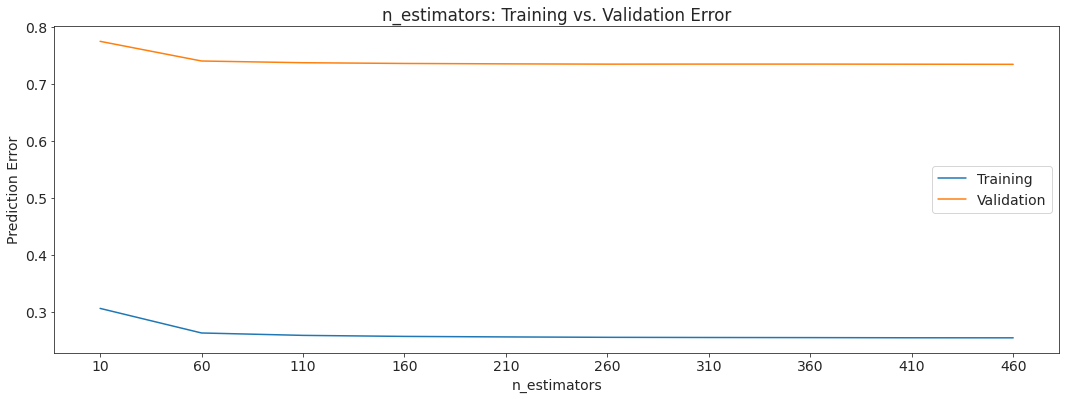

In [ ]:
plot_fitting_curve('n_estimators',est_error_df,10,500,50)

In [ ]:
%%time
mdepth_error_df=pd.DataFrame([tune_hyperParams_lgbm(x,n_estimators=60, max_depth=x) for x in range(2,22,4)])

CPU times: user 19min 20s, sys: 2.48 s, total: 19min 22s
Wall time: 2min 39s


In [ ]:
mdepth_error_df.sort_values('Validation Error').head(5)

,param_value,Training Error,Validation Error
4,18,0.6510,0.7509
3,14,0.7416,0.7704
2,10,0.8001,0.7977
1,6,0.8357,0.8292
0,2,0.8627,0.8569


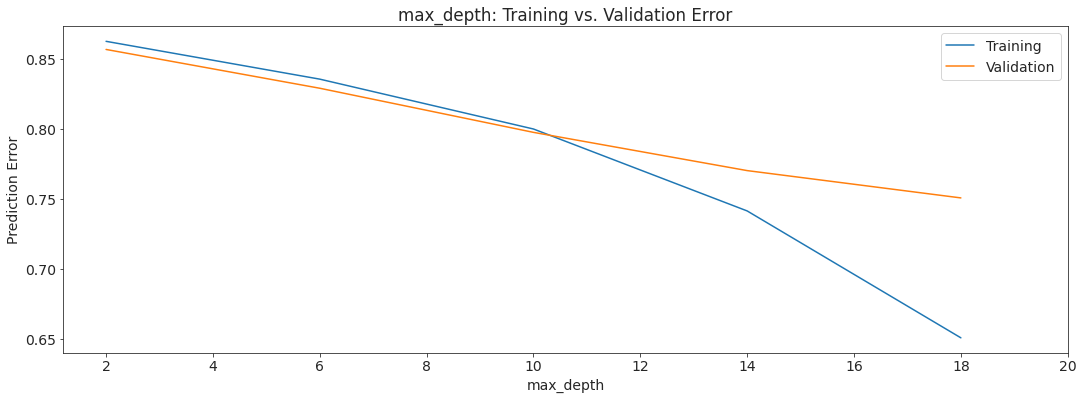

In [ ]:
plot_fitting_curve('max_depth',mdepth_error_df,2,22,2)

Generate Model with optimum hyper tuned parameters.

In [ ]:
%%time
import lightgbm as lgbm
rfrf=RandomForestRegressor(random_state=42, n_jobs=-1,n_estimators=60 , max_depth=14)
rfrf,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(rfrf)

Training mean_squared_error for      RandomForestRegressor: 0.7417877537270994 
Training NWRMSLE for                  RandomForestRegressor: 0.7418 
Training mean_squared_log_error for  RandomForestRegressor: 0.26762214083598374 
Validation mean_squared_error for     RandomForestRegressor: 0.770579139958658 
Validation NWRMSLE for                 RandomForestRegressor: 0.7706 
Validation mean_squared_log_error for RandomForestRegressor: 0.28105093072399967 
CPU times: user 5min 8s, sys: 271 ms, total: 5min 8s
Wall time: 43.6 s


In [ ]:
predict_and_submit_test_dataset(rfrf,'rfrf_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


#### Select best performing Model. 

Based on serveral iteration of the HyperPrameter tuning . The most optimum performance is obtained from model XGBRegressor with following hyperParameters. max_depth=14,n_estimators=225,learning_rate=0.2,colsample_bytree=0.8 . 
These parameters give a NWRMSLE error 0.6308 and a Kaggle score of 1.07

In [ ]:
%%time
from xgboost import XGBRegressor
xgbf=XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squaredlogerror',eval_metric='rmsle',max_depth=14,n_estimators=225,learning_rate=0.2,colsample_bytree=0.8)

xgbf,model_name,v_NWRMSLE,v_msre,v_mrsle=checkModelPerformance(xgbf)

Training mean_squared_error for      XGBRegressor: 0.5127097824254536 
Training NWRMSLE for                  XGBRegressor: 0.5127 
Training mean_squared_log_error for  XGBRegressor: 0.17973805878126903 
Validation mean_squared_error for     XGBRegressor: 0.6308353104048244 
Validation NWRMSLE for                 XGBRegressor: 0.6308 
Validation mean_squared_log_error for XGBRegressor: 0.22788445844966962 
CPU times: user 18min 42s, sys: 2.63 s, total: 18min 44s
Wall time: 2min 23s


#### Save the best performing model.

In [ ]:
import joblib
#save Model
joblib.dump(xgbf,'final_xgb_model.bin')

['final_xgb_model.bin']

Load the Model from the saved file.

In [ ]:
import joblib
#Load Model
xgbf=joblib.load('final_xgb_model.bin')

In [ ]:
predict_and_submit_test_dataset(xgbf,'xgbf_submission.csv')

Number of predictions to be made    :  3370464
Number of predictions actually made :  3370464


Feature Importance of the final model.

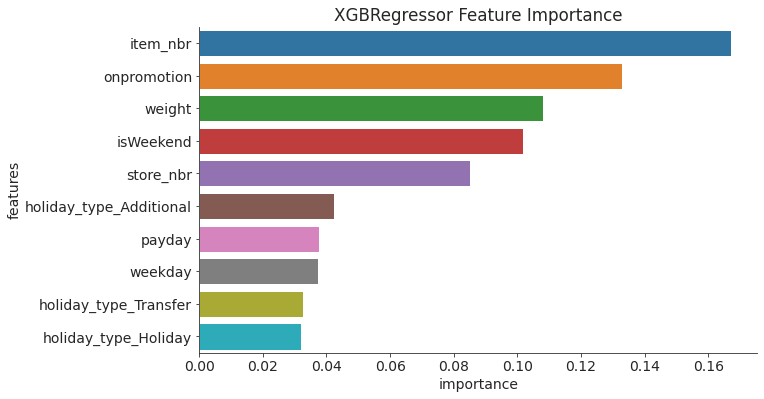

In [ ]:
xgbf.fit(input_training_df,target_training_df)
plot_feature_importance(input_training_df.columns,xgbf.feature_importances_,type(xgbf).__name__)

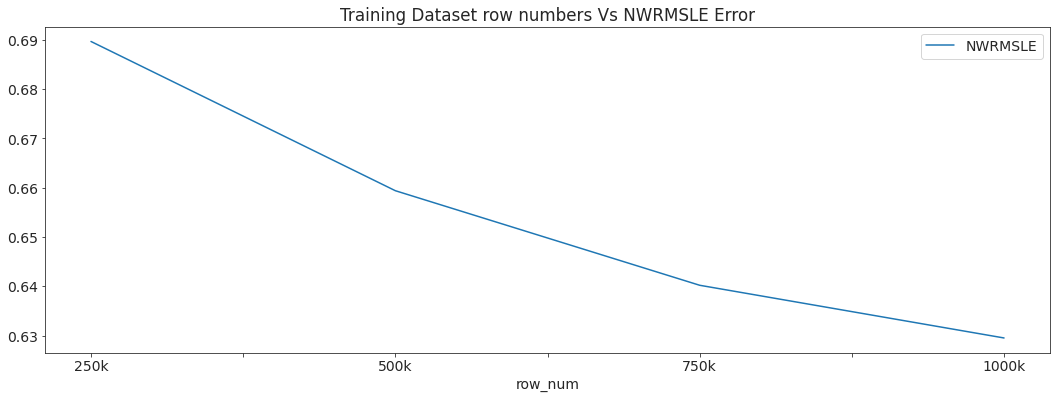

In [ ]:
pd.DataFrame({'row_num':['250k','500k','750k','1000k'], 'NWRMSLE':[0.6897,0.6594,0.6402,0.6295]}).plot(x='row_num')
plt.title("Training Dataset row numbers Vs NWRMSLE Error");

The above graph shows the more the rows in training dataset lesser the error.

In [ ]:

import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
##set up the parameters
rcParams['figure.figsize'] = 200,200
%matplotlib inline 

In [ ]:
%%time
plot_tree(xgbf, rankdir='LR',num_trees=1,);

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.353626 to fit


CPU times: user 15.5 s, sys: 1.03 s, total: 16.6 s
Wall time: 30.6 s


Sample predictions from validation dataset and test datasets

In [ ]:
input_val_data_w_preds_df=input_val_data_df.copy(deep=True)
input_val_data_w_preds_df['unit_sales']=np.exp(target_val_df)-1
input_val_data_w_preds_df['prediction']=np.exp(xgbf.predict(input_val_data_df))-1
input_val_data_w_preds_df[['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','unit_sales','prediction']].sample(n=5)

,store_nbr,item_nbr,onpromotion,isHoliday,unit_sales,prediction
979444,26,1058820,0,0.0,1.000000,1.601646
1170553,27,1463855,0,0.0,37.999996,18.508680
948277,30,1053944,0,0.0,3.000000,1.235355
1093058,46,2049778,0,0.0,19.000002,3.436687
915462,33,929893,0,0.0,2.000000,1.117628


In [ ]:
ml_test_preds_df=ml_test_df.copy(deep=True)
ml_test_preds_df['prediction']=np.exp(xgbf.predict(ml_test_df))-1
#ml_test_preds_df[['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','prediction']].sample(n=5)

display(ml_test_preds_df.loc[(ml_test_preds_df.store_nbr==26) & (ml_test_preds_df.item_nbr==1058820	)][['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','prediction']].sample(n=1))
display(ml_test_preds_df.loc[(ml_test_preds_df.store_nbr==27) & (ml_test_preds_df.item_nbr==1463855	)][['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','prediction']].sample(n=1))
display(ml_test_preds_df.loc[(ml_test_preds_df.store_nbr==30) & (ml_test_preds_df.item_nbr==1053944	)][['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','prediction']].sample(n=1))
display(ml_test_preds_df.loc[(ml_test_preds_df.store_nbr==46) & (ml_test_preds_df.item_nbr==2049778	)][['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','prediction']].sample(n=1))
display(ml_test_preds_df.loc[(ml_test_preds_df.store_nbr==33) & (ml_test_preds_df.item_nbr==929893	)][['store_nbr',	'item_nbr',	'onpromotion',	'isHoliday','prediction']].sample(n=1))

,store_nbr,item_nbr,onpromotion,isHoliday,prediction
98981,26,1058820,0,0.0,1.485375


,store_nbr,item_nbr,onpromotion,isHoliday,prediction
2210428,27,1463855,0,0.0,32.517361


,store_nbr,item_nbr,onpromotion,isHoliday,prediction
3063731,30,1053944,0,0.0,1.214338


,store_nbr,item_nbr,onpromotion,isHoliday,prediction
2707104,46,2049778,0,0.0,2.541008


,store_nbr,item_nbr,onpromotion,isHoliday,prediction
1600634,33,929893,0,0.0,1.056525


Observation:  
 predictions for testing dataset are closer to the actual values of similar looking datapoints from training dataset. 

Predictions distribution of Test dataset Vs Actual `unit_sales` from Training Dataset.

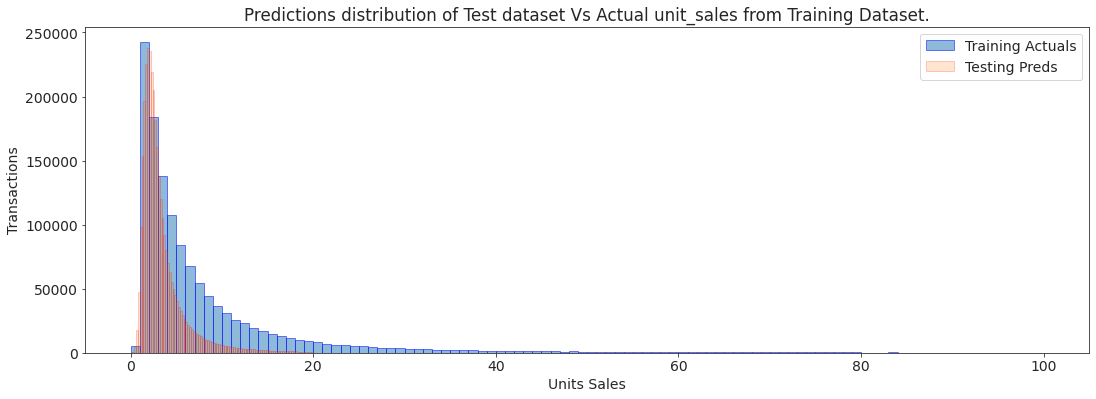

In [ ]:
plt.hist(ml_train_tget_df['unit_sales'], bins=100,range=(0,100),alpha=.5, edgecolor='blue')
plt.hist(ml_test_preds_df['prediction'], bins=100,range=(0,20),alpha=.2, edgecolor='red')
plt.title('Predictions distribution of Test dataset Vs Actual unit_sales from Training Dataset.')
plt.xlabel('Units Sales')
plt.ylabel('Transactions')
plt.legend(['Training Actuals','Testing Preds'])
plt.show()

Observation:  
The overall distribution of `unit_sales` in training dataset is similar to overall distribution of predictions for the training dataset, especially if the values are at the lower end of the spectrem.

## Summary & Insights

### Summary:  
In this project, we have explored Supervised Machine Learning methods to predict sales of each item at each store on each day. We have tried both Linear, Tree based and Ensemble models. Linear Models such as- **Linear**,**Ridge**,**Lasso**,**ElasticNet**. Tree Based models such as- **Decision Tree**,**Random Forest**,**BaggingRegressor**,**XGBoostRegressor**,**LGBMRegressor** and Ensemble models such as-**AdaBoostRegressor**,**StackingRegressor**.  We used **Pandas**, **Numpy**, **Matplotlib**, **Seaborn** and **Plotl**y to perform the exploratory data analysis and gather insights  into the data and prepare the data for machine learning.  
* We used 1%(1.2M) of training data.  
* We prepared the data with the following steps:  
  * Removed duplicates.
  * merge train dataset with other features.
  * impute missing values , we have adopted two strategies.  
    * ffill(forward fill), bfill(backward fill) for oil price.
    * use XGBoost Model to predict missing values for transactions.
    * static value for `onpromotion`.
* Remove outliers.
* Add new columns with extracted parts of `date`.
* Add a column to represent date as a numeric value.
* Add new columns to capture the nature of the day, ex: isWeekend,isHoliday,isPaday etc.
* Perform OneHotEncoded on `holiday_type`.  
* Select input features , this is based on:  
   * Eliminating input columns with high correlation with each other.
   * Based on EDA (see EDA section)
   * Basic intution.
* Convert the target column(`unit_sales`) to its log(ln) value.  
* Training data was split with a 70:30 train:Validation datasets.
* The Models took in the train-validation datasets and returned NWRMSLE error score.
* **XGBoost** and **RandomForest** gave us the least error. We chose XGBoost regressor for HyperParameter tyuning as this gave the least Kaggle score.
* `XGBRegressor(random_state=42, n_jobs=-1,  objective ='reg:squaredlogerror',eval_metric='rmsle',max_depth=14,n_estimators=225,learning_rate=0.2,colsample_bytree=0.8)` gave the best performance with NWRMSLE 0.6284 and a Kaggle score of 1.07.
* convert target column back to its non-log(np.exp) form.
* Saved the best performing model to a file using `joblib` library.
* Load the Model from the file.
* Used the best performing model to generate predictions for test dataset and submitted to Kaggle.
* Due to hardware resource constraint, we trained the model only on 1% i.e.1.2M of the data. As we can see from the graph, more the data, lesser the error.
 

### Insights and Observations:  
* There is such a thing as curse of dimentionality. We noticed that more number of input features/columns resulted in higer error. We had to perform feature pruning to get to the best performing model.
* NWRMSLE score on validation dataset does not corelate to the Kaggle score on test dataset. This could be disproportionate dataset ratio(1:10). 
* The model performed better when numerical categorical data is reated as numeric value instead of OneHotEncoded feature.
* The model performed better when the data is not scaled.  
* The model performed better when the unit_sales was convered to a log value.
* As shown in the above chart. the Predictions on the test dataset and actual sales of the training dataset has similar distribution, especially when predicting smaller number. This suggest that the model predictions are on the conservative side. 
* This is confrimed by the sandom sampling of actuals & predictions for similar input data points as shown.


### Suggestions for Future Work.
* Feature Selection with PCA,LabelEncoders etc.
* Since data very skewd with relation to store and item, multiple models for store and item combination can be explored.
* Build a effiencient data processing pipeline.
* Since the data spans multiple years and customer behavious changes. A time series model such as ARIMA and SARIMA for forecasting.
* Build a Web page to take in input such as `date`,`stor_nbr` & `'item_number` and displays units expected to sell.


### References  
Tutorials
How to approach Machine Learning Problems [Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/how-to-approach-machine-learning-problems)  
Gradient Boosting Machines with XGBoost [Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/gradient-boosting-machines-with-xgboost)

Books & Articles:  
Hands-on Machine Learning with scikit-Learn, Keras & TensorFlow (O'Reilly)  
